In [30]:
# =========================================
# 1. Importação de bibliotecas
# =========================================
# Bibliotecas para manipulação e análise de dados
import pandas as pd          # Para manipulação de DataFrames e análise de dados
import numpy as np           # Para operações numéricas e arrays
import matplotlib.pyplot as plt  # Para criação de gráficos e visualizações
import seaborn as sns        # Para gráficos estatísticos mais atrativos

# Bibliotecas de Machine Learning do scikit-learn
from sklearn.model_selection import KFold  # Para validação cruzada k-fold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Métricas de avaliação
from sklearn.ensemble import RandomForestRegressor  # Algoritmo Random Forest
from sklearn.preprocessing import LabelEncoder  # Para codificação de variáveis categóricas

# Bibliotecas de algoritmos avançados de Machine Learning
from xgboost import XGBRegressor      # Algoritmo XGBoost para regressão
from lightgbm import LGBMRegressor    # Algoritmo LightGBM para regressão

# Bibliotecas estatísticas e utilitárias
from scipy.stats import mstats, pearsonr  # Para winsorização e correlação de Pearson
import warnings                           # Para controle de avisos
import pickle                            # Para salvar/carregar modelos treinados
import os                                # Para operações de sistema de arquivos

# Configuração global para suprimir avisos desnecessários durante a execução
warnings.filterwarnings("ignore")

# Configuração visual padrão para todos os gráficos gerados
# style="whitegrid": fundo branco com grade para melhor visualização
# palette="pastel": cores suaves e agradáveis aos olhos
# font_scale=1.2: tamanho da fonte ligeiramente aumentado para melhor legibilidade
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)


In [31]:
# =========================================
# 2. Definição da classe principal com dashboard avançado e resultados completos
# =========================================
class PreditordeDesmatamentoAvancado:
    """
    Classe principal para predição de desmatamento usando modelos de Machine Learning.
    Inclui dashboard avançado com visualizações comparativas, resultados em texto e gráficos intuitivos.
    """
    def __init__(self):
        # Configuração dos modelos
        self.modelos = {
            "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
            "XGBoost": XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
            "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1)
        }
        # Arquivos para persistência
        self.arquivos_modelo = {
            "RandomForest": "RandomForest_modelo.pkl",
            "XGBoost": "XGBoost_modelo.pkl",
            "LightGBM": "LightGBM_modelo.pkl"
        }

        # Configuração de cores para visualizações consistentes
        self.cores_modelos = {
            "RandomForest": "#FF6B6B",      # Vermelho coral
            "XGBoost": "#4ECDC4",           # Verde azulado
            "LightGBM": "#45B7D1"           # Azul
        }

        # Cores para dados reais vs previsões
        self.cores_comparacao = {
            "dados_reais": "#2E8B57",       # Verde mar
            "previsoes": "#FF6347",         # Tomate
            "linha_perfeita": "#FFD700"     # Dourado
        }

        print("✅ Classe PreditordeDesmatamentoAvancado criada com sucesso!")

    def carregar_dados(self, arquivo_csv):
        """Carrega dados de desmatamento com detecção automática de delimitador."""
        for sep in ['\t', ',', ';']:
            try:
                df = pd.read_csv(arquivo_csv, sep=sep)
                if 'viewDate' in df.columns:
                    print(f"✅ Dados carregados com {df.shape[0]} linhas e {df.shape[1]} colunas (delimitador '{sep}')")
                    return df
            except Exception:
                continue
        raise ValueError("Não foi possível detectar o delimitador ou coluna 'viewDate' não encontrada.")

    def preparar_dados(self, df):
        """Pré-processa e prepara os dados para treinamento."""
        print("🔧 Iniciando pré-processamento dos dados...")

        # Processamento temporal
        df['viewDate'] = pd.to_datetime(df['viewDate'], dayfirst=True, errors='coerce')
        df = df.dropna(subset=['viewDate'])

        # Features temporais
        df['year'] = df['viewDate'].dt.year
        df['month'] = df['viewDate'].dt.month
        df['day'] = df['viewDate'].dt.day
        df['weekday'] = df['viewDate'].dt.weekday
        df['quarter'] = df['viewDate'].dt.quarter

        # Tratamento de outliers
        df['areaMunKm_winsor'] = mstats.winsorize(df['areaMunKm'], limits=[0.01, 0.01])

        # Transformação logarítmica
        df['target_log'] = np.log1p(df['areaMunKm_winsor'])

        # Seleção de features
        X = df[['areaUcKm', 'year', 'month', 'day', 'weekday', 'quarter', 'uf', 'className']].copy()

        # Tratamento de valores ausentes
        X['areaUcKm'] = X['areaUcKm'].fillna(0)

        # Engenharia de features
        X['areaUcKm_year'] = X['areaUcKm'] * X['year']

        # Codificação de variáveis categóricas
        for col in ['uf', 'className']:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

        y = df['target_log']
        return X, y, df

    def verificar_modelos_existentes(self):
        """Verifica se os modelos já foram treinados."""
        modelos_existentes = []
        for nome, arquivo in self.arquivos_modelo.items():
            if os.path.exists(arquivo):
                print(f"✅ Modelo {nome} encontrado: {arquivo}")
                modelos_existentes.append(nome)
            else:
                print(f"❌ Modelo {nome} não encontrado: {arquivo}")
        return len(modelos_existentes) > 0

    def carregar_modelos_existentes(self):
        """Carrega modelos salvos anteriormente."""
        for nome, arquivo in self.arquivos_modelo.items():
            if os.path.exists(arquivo):
                with open(arquivo, 'rb') as f:
                    self.modelos[nome] = pickle.load(f)
                print(f"✅ Modelo {nome} carregado: {arquivo}")

    def cross_validate_modelos(self, X, y, n_splits=5):
        """Executa validação cruzada k-fold para todos os modelos."""
        from sklearn.model_selection import KFold

        resultados = {nome: {
            'rmse': [], 'mae': [], 'medae': [], 'mape': [], 'r2': [], 'pearson_r': []
        } for nome in self.modelos.keys()}

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
            print(f"➡️ Fold {fold} de {n_splits}")
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            for nome, modelo in self.modelos.items():
                modelo.fit(X_train, y_train)
                preds_log = modelo.predict(X_test)

                # Conversão para escala original
                preds = np.expm1(preds_log)
                y_true = np.expm1(y_test)

                # Cálculo das métricas
                rmse = np.sqrt(mean_squared_error(y_true, preds))
                mae = mean_absolute_error(y_true, preds)
                medae = np.median(np.abs(y_true - preds))
                mape = np.mean(np.abs((y_true - preds) / (y_true + 1e-9))) * 100
                r2 = r2_score(y_true, preds)
                pearson_r = np.corrcoef(y_true, preds)[0, 1]

                # Armazenamento dos resultados
                resultados[nome]['rmse'].append(rmse)
                resultados[nome]['mae'].append(mae)
                resultados[nome]['medae'].append(medae)
                resultados[nome]['mape'].append(mape)
                resultados[nome]['r2'].append(r2)
                resultados[nome]['pearson_r'].append(pearson_r)

        # Cálculo das médias
        resumo = {}
        for nome in self.modelos.keys():
            resumo[nome] = {
                'rmse': np.mean(resultados[nome]['rmse']),
                'mae': np.mean(resultados[nome]['mae']),
                'medae': np.mean(resultados[nome]['medae']),
                'mape': np.mean(resultados[nome]['mape']),
                'r2': np.mean(resultados[nome]['r2']),
                'pearson_r': np.mean(resultados[nome]['pearson_r'])
            }

        return resumo

    def exibir_resultados_previsao_comparativa(self, df, preds_finais):
        """
        Exibe em texto os resultados de previsão das áreas que serão desmatadas,
        comparando com os valores reais do dataset para os três algoritmos.
        """
        print("\n" + "="*100)
        print("🌳 RESULTADOS DE PREVISÃO DE DESMATAMENTO - COMPARAÇÃO COMPLETA")
        print("="*100)

        # Calcula métricas de erro para cada modelo
        y_true = df['areaMunKm'].values
        erros_modelos = {}

        for nome_modelo, previsoes in preds_finais.items():
            # RMSE
            rmse = np.sqrt(mean_squared_error(y_true, previsoes))
            # MAE
            mae = mean_absolute_error(y_true, previsoes)
            # MAPE
            mape = np.mean(np.abs((y_true - previsoes) / (y_true + 1e-9))) * 100
            # R²
            r2 = r2_score(y_true, previsoes)
            # Pearson r
            pearson_r = np.corrcoef(y_true, previsoes)[0, 1]

            erros_modelos[nome_modelo] = {
                'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'pearson_r': pearson_r
            }

        # Ranking dos modelos por RMSE (menor = melhor)
        ranking = sorted(erros_modelos.items(), key=lambda x: x[1]['rmse'])

        # Exibe resultados ordenados
        for i, (nome_modelo, metricas) in enumerate(ranking, 1):
            if i == 1:
                medal = "🥇"
                posicao = "1º"
            elif i == 2:
                medal = "🥈"
                posicao = "2º"
            elif i == 3:
                medal = "🥉"
                posicao = "3º"
            else:
                medal = f"{i}º"
                posicao = f"{i}º"

            print(f"\n{medal} {posicao} {nome_modelo} – Previsão vs Área Real")
            print("-" * 80)
            print(f"📊 Métricas de Performance:")
            print(f"   • RMSE: {metricas['rmse']:.4f} km²")
            print(f"   • MAE: {metricas['mae']:.4f} km²")
            print(f"   • MAPE: {metricas['mape']:.2f}%")
            print(f"   • R²: {metricas['r2']:.4f}")
            print(f"   • Pearson r: {metricas['pearson_r']:.4f}")

            # Seleciona 5 amostras aleatórias para demonstração
            indices_amostra = np.random.choice(len(df), 5, replace=False)
            print(f"\n�� Amostras de Previsões vs Valores Reais:")

            for j, idx in enumerate(indices_amostra, 1):
                valor_real = df.iloc[idx]['areaMunKm']
                valor_previsto = preds_finais[nome_modelo][idx]
                erro_abs = abs(valor_previsto - valor_real)
                erro_perc = (erro_abs / valor_real) * 100 if valor_real > 0 else 0

                print(f"   Amostra {j}:")
                print(f"     �� Data: {df.iloc[idx]['viewDate']}")
                print(f"     🏛️ UF: {df.iloc[idx]['uf']}")
                print(f"     🌳 Área Real: {valor_real:.4f} km²")
                print(f"     🎯 Previsão: {valor_previsto:.4f} km²")
                print(f"     ❌ Erro Absoluto: {erro_abs:.4f} km²")
                print(f"     �� Erro Percentual: {erro_perc:.1f}%")
                print()

        # Resumo comparativo final
        print("="*100)
        print("�� RESUMO COMPARATIVO FINAL")
        print("="*100)

        melhor_modelo = ranking[0][0]
        pior_modelo = ranking[-1][0]

        print(f"\n�� MELHOR PERFORMANCE: {melhor_modelo}")
        print(f"   • RMSE: {erros_modelos[melhor_modelo]['rmse']:.4f} km²")
        print(f"   • R²: {erros_modelos[melhor_modelo]['r2']:.4f}")
        print(f"   • Acurácia Relativa: {(1 - erros_modelos[melhor_modelo]['mae']/np.mean(y_true))*100:.1f}%")

        print(f"\n🥉 PIOR PERFORMANCE: {pior_modelo}")
        print(f"   • RMSE: {erros_modelos[pior_modelo]['rmse']:.4f} km²")
        print(f"   • R²: {erros_modelos[pior_modelo]['r2']:.4f}")
        print(f"   • Acurácia Relativa: {(1 - erros_modelos[pior_modelo]['mae']/np.mean(y_true))*100:.1f}%")

        # Análise de diferenças
        diff_rmse = erros_modelos[pior_modelo]['rmse'] - erros_modelos[melhor_modelo]['rmse']
        diff_r2 = erros_modelos[melhor_modelo]['r2'] - erros_modelos[pior_modelo]['r2']

        print(f"\n�� ANÁLISE DE DIFERENÇAS:")
        print(f"   • Diferença de RMSE: {diff_rmse:.4f} km²")
        print(f"   • Diferença de R²: {diff_r2:.4f}")
        print(f"   • Melhoria percentual: {(diff_rmse/erros_modelos[pior_modelo]['rmse'])*100:.1f}%")

        print("\n" + "="*100)

    def imprimir_resultados_detalhados(self, resumo):
        """Imprime resultados detalhados da validação cruzada."""
        print("\n📊 PASSO 4: RESULTADOS DETALHADOS")
        print("=" * 60)
        print("\n📊 RESULTADOS DETALHADOS - K-Fold Cross Validation")
        print("=" * 80)
        print(f"{'Modelo':<15} {'RMSE':<10} {'MAE':<10} {'MAPE (%)':<12} {'R²':<8} {'Pearson r':<12}")
        print("=" * 80)

        for nome, metricas in resumo.items():
            rmse = metricas['rmse']
            mae = metricas['mae']
            mape = metricas['mape']
            r2 = metricas['r2']
            pearson = metricas['pearson_r']
            print(f"{nome:<15} {rmse:<10.4f} {mae:<10.4f} {mape:<12.2f} {r2:<8.4f} {pearson:<12.4f}")

        print("=" * 80)

    def imprimir_dashboard_resumido(self, resumo):
        """Imprime dashboard resumido com formatação visual melhorada."""
        print("\n" + "🎯" + "=" * 58 + "🎯")
        print(" DASHBOARD COMPLETO - RESULTADOS DOS MODELOS")
        print("" + "=" * 58 + "")

        # Tabela principal de resultados
        print("\n📊 RESULTADOS COMPARATIVOS DOS MODELOS:")
        print("─" * 80)
        print(f"{'Modelo':<15} {'RMSE':<10} {'MAE':<10} {'MAPE (%)':<12} {'R²':<8} {'Pearson r':<12}")
        print("─" * 80)

        for nome, metricas in resumo.items():
            rmse = metricas['rmse']
            mae = metricas['mae']
            mape = metricas['mape']
            r2 = metricas['r2']
            pearson = metricas['pearson_r']
            print(f"{nome:<15} {rmse:<10.4f} {mae:<10.4f} {mape:<12.2f} {r2:<8.4f} {pearson:<12.4f}")

        print("─" * 80)

        # Ranking dos modelos
        print("\n🏅 RANKING DOS MODELOS (do melhor ao pior):")
        ranking = sorted(resumo.items(), key=lambda x: (x[1]['rmse'], -x[1]['r2']))
        for i, (nome, metricas) in enumerate(ranking, 1):
            if i == 1:
                medal = "🥇"
            elif i == 2:
                medal = "🥈"
            elif i == 3:
                medal = "🥉"
            else:
                medal = f"{i}º"
            print(f"   {medal} {nome:<12} - RMSE: {metricas['rmse']:.4f}, R²: {metricas['r2']:.4f}")

        # Informações sobre os dados
        print("\n📈 INFORMAÇÕES SOBRE O DATASET:")
        print("   • Total de registros: 18,573")
        print("   • Features utilizadas: 9")
        print("   • Validação cruzada: 5 folds")
        print("   • Dados de treino por fold: ~14,858")
        print("   • Dados de teste por fold: ~3,714")
        print("\n🎯" + "=" * 58 + "🎯")

    def plot_metricas_barras(self, resumo):
        """Gera gráficos de barras simples e intuitivos."""
        print("📈 Gerando gráficos de comparação de métricas...")

        # Cria figura com 2 linhas e 3 colunas para melhor organização
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('🏆 COMPARAÇÃO DE MODELOS - DESMATAMENTO AMAZÔNICO', fontsize=18, fontweight='bold', y=0.98)

        # Cores consistentes para cada modelo
        cores = {'RandomForest': '#FF6B6B', 'XGBoost': '#4ECDC4', 'LightGBM': '#45B7D1'}
        modelos = list(resumo.keys())

        # 1. RMSE - Quanto menor, melhor
        rmse_values = [resumo[nome]['rmse'] for nome in modelos]
        bars1 = axes[0, 0].bar(modelos, rmse_values, color=[cores[nome] for nome in modelos], alpha=0.8)
        axes[0, 0].set_title('📊 RMSE (Erro Quadrático Médio)', fontweight='bold', fontsize=14)
        axes[0, 0].set_ylabel('RMSE', fontweight='bold')
        axes[0, 0].set_ylim(0, max(rmse_values) * 1.1)

        # Adiciona valores nas barras
        for bar, valor in zip(bars1, rmse_values):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{valor:.4f}', ha='center', va='bottom', fontweight='bold')

        # 2. MAE - Quanto menor, melhor
        mae_values = [resumo[nome]['mae'] for nome in modelos]
        bars2 = axes[0, 1].bar(modelos, mae_values, color=[cores[nome] for nome in modelos], alpha=0.8)
        axes[0, 1].set_title('�� MAE (Erro Absoluto Médio)', fontweight='bold', fontsize=14)
        axes[0, 1].set_ylabel('MAE', fontweight='bold')
        axes[0, 1].set_ylim(0, max(mae_values) * 1.1)

        # Adiciona valores nas barras
        for bar, valor in zip(bars2, mae_values):
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{valor:.4f}', ha='center', va='bottom', fontweight='bold')

        # 3. MAPE - Quanto menor, melhor
        mape_values = [resumo[nome]['mape'] for nome in modelos]
        bars3 = axes[0, 2].bar(modelos, mape_values, color=[cores[nome] for nome in modelos], alpha=0.8)
        axes[0, 2].set_title('�� MAPE (Erro Percentual)', fontweight='bold', fontsize=14)
        axes[0, 2].set_ylabel('MAPE (%)', fontweight='bold')
        axes[0, 2].set_ylim(0, max(mape_values) * 1.1)

        # Adiciona valores nas barras
        for bar, valor in zip(bars3, mape_values):
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 1, f'{valor:.2f}%', ha='center', va='bottom', fontweight='bold')

        # 4. R² - Quanto maior, melhor
        r2_values = [resumo[nome]['r2'] for nome in modelos]
        bars4 = axes[1, 0].bar(modelos, r2_values, color=[cores[nome] for nome in modelos], alpha=0.8)
        axes[1, 0].set_title('�� R² (Coeficiente de Determinação)', fontweight='bold', fontsize=14)
        axes[1, 0].set_ylabel('R²', fontweight='bold')
        axes[1, 0].set_ylim(0, max(r2_values) * 1.1)

        # Adiciona valores nas barras
        for bar, valor in zip(bars4, r2_values):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{valor:.4f}', ha='center', va='bottom', fontweight='bold')

        # 5. Pearson r - Quanto maior, melhor
        pearson_values = [resumo[nome]['pearson_r'] for nome in modelos]
        bars5 = axes[1, 1].bar(modelos, pearson_values, color=[cores[nome] for nome in modelos], alpha=0.8)
        axes[1, 1].set_title('📊 Pearson r (Correlação)', fontweight='bold', fontsize=14)
        axes[1, 1].set_ylabel('Pearson r', fontweight='bold')
        axes[1, 1].set_ylim(0, max(pearson_values) * 1.1)

        # Adiciona valores nas barras
        for bar, valor in zip(bars5, pearson_values):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{valor:.4f}', ha='center', va='bottom', fontweight='bold')

        # 6. MEDAE - Quanto menor, melhor
        medae_values = [resumo[nome]['medae'] for nome in modelos]
        bars6 = axes[1, 2].bar(modelos, medae_values, color=[cores[nome] for nome in modelos], alpha=0.8)
        axes[1, 2].set_title('📊 MEDAE (Mediana do Erro Absoluto)', fontweight='bold', fontsize=14)
        axes[1, 2].set_ylabel('MEDAE', fontweight='bold')
        axes[1, 2].set_ylim(0, max(medae_values) * 1.1)

        # Adiciona valores nas barras
        for bar, valor in zip(bars6, medae_values):
            height = bar.get_height()
            axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{valor:.4f}', ha='center', va='bottom', fontweight='bold')

        # Ajusta layout e exibe
        plt.tight_layout()
        plt.show()

        print("✅ Gráficos de comparação gerados com sucesso!")

    def plot_metricas_linhas(self, resumo):
        """Gera gráficos de linha para métricas de ajuste."""
        print("📈 Gerando gráficos de linha para métricas de ajuste...")

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle('�� MÉTRICAS DE AJUSTE - COMPARAÇÃO ENTRE MODELOS', fontsize=16, fontweight='bold')

        modelos = list(resumo.keys())

        # R²
        r2_values = [resumo[nome]['r2'] for nome in modelos]
        axes[0].plot(modelos, r2_values, marker='o', linestyle='-', color='mediumseagreen', linewidth=2, markersize=8)
        axes[0].set_title('R² (Coeficiente de Determinação)', fontweight='bold', fontsize=14)
        axes[0].set_ylabel('R²', fontweight='bold')
        axes[0].set_ylim(0, 1)
        axes[0].grid(True, linestyle='--', alpha=0.6)

        # Adiciona valores sobre os pontos
        for i, v in enumerate(r2_values):
            axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

        # Pearson r
        pearson_values = [resumo[nome]['pearson_r'] for nome in modelos]
        axes[1].plot(modelos, pearson_values, marker='o', linestyle='-', color='coral', linewidth=2, markersize=8)
        axes[1].set_title('Pearson r (Correlação)', fontweight='bold', fontsize=14)
        axes[1].set_ylabel('Pearson r', fontweight='bold')
        axes[1].set_ylim(0, 1)
        axes[1].grid(True, linestyle='--', alpha=0.6)

        # Adiciona valores sobre os pontos
        for i, v in enumerate(pearson_values):
            axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()
        print("✅ Gráficos de linha gerados com sucesso!")

    def plot_previsoes_todos_modelos(self, df, preds_finais):
        """Gera gráficos de dispersão para previsões vs valores reais."""
        print("📊 Gerando gráficos de previsões vs valores reais...")

        modelos = list(preds_finais.keys())
        n = len(modelos)
        plt.figure(figsize=(16, 5 * n))

        y_true = df['areaMunKm'].values

        # Remove outliers extremos para melhor visualização
        lower_lim = np.percentile(y_true, 1)
        upper_lim = np.percentile(y_true, 99)

        for i, modelo in enumerate(modelos, 1):
            plt.subplot(n, 1, i)
            y_pred = preds_finais[modelo]

            # Filtra outliers
            mask = (y_true >= lower_lim) & (y_true <= upper_lim) & (y_pred >= lower_lim) & (y_pred <= upper_lim)
            x_plot = y_true[mask]
            y_plot = y_pred[mask]

            plt.scatter(x_plot, y_plot, alpha=0.5, color='tab:blue', edgecolor='k', linewidth=0.3)
            plt.plot([lower_lim, upper_lim], [lower_lim, upper_lim], 'r--', lw=2)

            plt.xlim(lower_lim, upper_lim)
            plt.ylim(lower_lim, upper_lim)
            plt.xlabel('Valores Reais (Área Municipal Km²)', fontsize=12, fontweight='bold')
            plt.ylabel('Previsões (Área Municipal Km²)', fontsize=12, fontweight='bold')
            plt.title(f'Previsões vs Valores Reais - Modelo: {modelo}', fontsize=14, fontweight='bold')
            plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
        print("✅ Gráficos de previsões gerados com sucesso!")

    def plot_dashboard_comparativo_avancado(self, df, preds_finais):
        """
        Dashboard avançado com visualizações comparativas intuitivas das previsões.
        Inclui gráficos de linha, áreas sombreadas, barras comparativas e scatter plots sobrepostos.
        """
        print("🎨 Gerando dashboard comparativo avançado...")

        # Configuração da figura principal
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('�� DASHBOARD COMPARATIVO AVANÇADO - PREVISÕES DE DESMATAMENTO',
                     fontsize=20, fontweight='bold', y=0.98)

        # 1. GRÁFICO DE LINHA TEMPORAL COMPARATIVA
        ax1 = plt.subplot(3, 2, (1, 2))
        self._plot_linha_temporal_comparativa(ax1, df, preds_finais)

        # 2. SCATTER PLOT SOBREPOSTO COM LEGENDA
        ax2 = plt.subplot(3, 2, 3)
        self._plot_scatter_sobreposto(ax2, df, preds_finais)

        # 3. GRÁFICO DE BARRAS COMPARATIVAS DE ERRO
        ax3 = plt.subplot(3, 2, 4)
        self._plot_barras_erro_comparativo(ax3, df, preds_finais)

        # 4. GRÁFICO DE ÁREA SOMBREADA (PREVISÕES VS REAIS)
        ax4 = plt.subplot(3, 2, 5)
        self._plot_area_sombreada(ax4, df, preds_finais)

        # 5. GRÁFICO DE DISPERSÃO COM DENSIDADE
        ax5 = plt.subplot(3, 2, 6)
        self._plot_dispersao_densidade(ax5, df, preds_finais)

        plt.tight_layout()
        plt.show()
        print("✅ Dashboard comparativo avançado gerado com sucesso!")

    def _plot_linha_temporal_comparativa(self, ax, df, preds_finais):
        """Gráfico de linha temporal comparando previsões vs dados reais."""
        # Agrupa dados por ano para visualização temporal
        df_temp = df.copy()
        df_temp['year'] = pd.to_datetime(df_temp['viewDate']).dt.year

        # Calcula médias anuais
        dados_reais_anuais = df_temp.groupby('year')['areaMunKm'].mean()

        # Cria linha temporal para dados reais
        ax.plot(dados_reais_anuais.index, dados_reais_anuais.values,
                marker='o', linewidth=3, markersize=8,
                color=self.cores_comparacao['dados_reais'],
                label='Dados Reais', alpha=0.8)

        # Adiciona previsões de cada modelo
        for nome_modelo, previsoes in preds_finais.items():
            df_temp['pred'] = previsoes
            pred_anuais = df_temp.groupby('year')['pred'].mean()

            ax.plot(pred_anuais.index, pred_anuais.values,
                    marker='s', linewidth=2, markersize=6,
                    color=self.cores_modelos[nome_modelo],
                    label=f'Previsões {nome_modelo}', alpha=0.7)

        ax.set_title('�� EVOLUÇÃO TEMPORAL: Dados Reais vs Previsões por Ano',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
        ax.set_ylabel('Área Desmatada Média (Km²)', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10, loc='upper right')

        # Adiciona anotações de valores
        for i, valor in enumerate(dados_reais_anuais.values):
            ax.annotate(f'{valor:.1f}',
                       (dados_reais_anuais.index[i], valor),
                       textcoords="offset points", xytext=(0,10), ha='center',
                       fontsize=9, fontweight='bold')

    def _plot_scatter_sobreposto(self, ax, df, preds_finais):
        """Scatter plot sobreposto com todos os modelos."""
        y_true = df['areaMunKm'].values

        # Remove outliers para melhor visualização
        lower_lim = np.percentile(y_true, 1)
        upper_lim = np.percentile(y_true, 99)

        # Filtra dados
        mask = (y_true >= lower_lim) & (y_true <= upper_lim)
        x_plot = y_true[mask]

        # Plota dados reais
        ax.scatter(x_plot, x_plot, alpha=0.3, color=self.cores_comparacao['dados_reais'],
                  s=20, label='Dados Reais (Linha Perfeita)', marker='o')

        # Plota previsões de cada modelo
        for nome_modelo, previsoes in preds_finais.items():
            y_pred = previsoes[mask]
            ax.scatter(x_plot, y_pred, alpha=0.6,
                      color=self.cores_modelos[nome_modelo],
                      s=15, label=f'Previsões {nome_modelo}', marker='^')

        # Linha de referência perfeita
        ax.plot([lower_lim, upper_lim], [lower_lim, upper_lim],
                color=self.cores_comparacao['linha_perfeita'],
                linestyle='--', linewidth=2, alpha=0.8, label='Previsão Perfeita')

        ax.set_title('�� COMPARAÇÃO: Previsões vs Valores Reais',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Valores Reais (Km²)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Previsões (Km²)', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='upper left')
        ax.set_xlim(lower_lim, upper_lim)
        ax.set_ylim(lower_lim, upper_lim)

    def _plot_barras_erro_comparativo(self, ax, df, preds_finais):
        """Gráfico de barras comparando erros entre modelos."""
        y_true = df['areaMunKm'].values

        # Calcula métricas de erro para cada modelo
        erros_modelos = {}
        for nome_modelo, previsoes in preds_finais.items():
            # RMSE
            rmse = np.sqrt(mean_squared_error(y_true, previsoes))
            # MAE
            mae = mean_absolute_error(y_true, previsoes)
            # MAPE
            mape = np.mean(np.abs((y_true - previsoes) / (y_true + 1e-9))) * 100

            erros_modelos[nome_modelo] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

        # Prepara dados para o gráfico
        modelos = list(erros_modelos.keys())
        metricas = ['RMSE', 'MAE', 'MAPE']

        x = np.arange(len(modelos))
        width = 0.25

        # Cria barras agrupadas para cada métrica
        for i, metrica in enumerate(metricas):
            valores = [erros_modelos[mod][metrica] for mod in modelos]
            ax.bar(x + i*width, valores, width,
                  label=metrica, alpha=0.8,
                  color=[self.cores_modelos[mod] for mod in modelos])

        ax.set_title('📊 COMPARAÇÃO DE ERROS: RMSE, MAE e MAPE',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
        ax.set_ylabel('Valor do Erro', fontsize=12, fontweight='bold')
        ax.set_xticks(x + width)
        ax.set_xticklabels(modelos)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

        # Adiciona valores sobre as barras
        for i, metrica in enumerate(metricas):
            for j, mod in enumerate(modelos):
                valor = erros_modelos[mod][metrica]
                ax.text(j + i*width, valor + valor*0.01, f'{valor:.2f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

    def _plot_area_sombreada(self, ax, df, preds_finais):
        """Gráfico de área sombreada mostrando intervalo de previsões."""
        y_true = df['areaMunKm'].values

        # Remove outliers
        lower_lim = np.percentile(y_true, 1)
        upper_lim = np.percentile(y_true, 99)
        mask = (y_true >= lower_lim) & (y_true <= upper_lim)
        x_plot = y_true[mask]

        # Ordena dados para área sombreada
        sort_idx = np.argsort(x_plot)
        x_sorted = x_plot[sort_idx]

        # Calcula estatísticas das previsões
        preds_array = np.array([preds_finais[mod][mask] for mod in preds_finais.keys()])
        preds_sorted = preds_array[:, sort_idx]

        # Média e desvio padrão das previsões
        media_preds = np.mean(preds_sorted, axis=0)
        std_preds = np.std(preds_sorted, axis=0)

        # Plota área sombreada
        ax.fill_between(x_sorted, media_preds - std_preds, media_preds + std_preds,
                       alpha=0.3, color='lightblue', label='±1 Desvio Padrão')
        ax.fill_between(x_sorted, media_preds - 2*std_preds, media_preds + 2*std_preds,
                       alpha=0.2, color='lightblue', label='±2 Desvios Padrão')

        # Plota linha da média das previsões
        ax.plot(x_sorted, media_preds, color='blue', linewidth=2,
               label='Média das Previsões', alpha=0.8)

        # Plota dados reais
        ax.scatter(x_plot, y_true[mask], alpha=0.5, color=self.cores_comparacao['dados_reais'],
                  s=10, label='Dados Reais')

        # Linha de referência
        ax.plot([lower_lim, upper_lim], [lower_lim, upper_lim],
                color=self.cores_comparacao['linha_perfeita'],
                linestyle='--', linewidth=2, alpha=0.8, label='Previsão Perfeita')

        ax.set_title('🌊 INTERVALO DE CONFIANÇA: Previsões com Área Sombreada',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Valores Reais (Km²)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Previsões (Km²)', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='upper left')
        ax.set_xlim(lower_lim, upper_lim)

    def _plot_dispersao_densidade(self, ax, df, preds_finais):
        """Gráfico de dispersão com densidade de pontos."""
        y_true = df['areaMunKm'].values

        # Remove outliers
        lower_lim = np.percentile(y_true, 1)
        upper_lim = np.percentile(y_true, 99)
        mask = (y_true >= lower_lim) & (y_true <= upper_lim)
        x_plot = y_true[mask]

        # Plota dados reais vs previsões do melhor modelo (menor RMSE)
        melhor_modelo = min(preds_finais.keys(),
                           key=lambda x: np.sqrt(mean_squared_error(y_true, preds_finais[x])))
        y_pred = preds_finais[melhor_modelo][mask]

        # Gráfico de dispersão com densidade
        ax.scatter(x_plot, y_pred, alpha=0.6, c=y_pred, cmap='viridis',
                  s=20, edgecolors='k', linewidth=0.5)

        # Linha de referência
        ax.plot([lower_lim, upper_lim], [lower_lim, upper_lim],
                color=self.cores_comparacao['linha_perfeita'],
                linestyle='--', linewidth=2, alpha=0.8, label='Previsão Perfeita')

        # Adiciona barra de cores
        scatter = ax.scatter([], [], c=[], cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='Valor da Previsão (Km²)')

        ax.set_title(f'🎨 DENSIDADE DE PREVISÕES: {melhor_modelo} (Melhor Modelo)',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Valores Reais (Km²)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Previsões (Km²)', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        ax.set_xlim(lower_lim, upper_lim)

    def pipeline_completo(self, arquivo_csv, forcar_treinamento=False):
        """Pipeline principal com lógica inteligente de treinamento."""
        print("🚀 INICIANDO ANÁLISE DE PREVISÃO DE DESMATAMENTO")
        print("=" * 60)

        # PASSO 1: Carregar dados
        print("\n📊 PASSO 1: Carregando dados...")
        df = self.carregar_dados(arquivo_csv)

        # PASSO 2: Preparar dados
        print("\n🔧 PASSO 2: Pré-processando dados...")
        X, y, df = self.preparar_dados(df)

        # PASSO 3: Verificar modelos existentes
        print("\n🔍 PASSO 3: Verificando modelos existentes...")
        modelos_existentes = self.verificar_modelos_existentes()

        if not forcar_treinamento and modelos_existentes:
            print("\n✅ Usando modelos pré-treinados!")
            self.carregar_modelos_existentes()
            modelos_treinados, preds_finais = self.treinar_final_e_gerar_previsoes(X, y, treinar_todos=False)

            # PASSO EXTRA: Exibir resultados comparativos em texto
            print("\n📝 PASSO EXTRA: Exibindo resultados comparativos...")
            self.exibir_resultados_previsao_comparativa(df, preds_finais)

            return None, modelos_treinados, preds_finais
        else:
            print("\n🚀 Treinando novos modelos...")
            resumo_cv = self.cross_validate_modelos(X, y)

            # PASSO 4: Dashboard
            print("\n�� PASSO 4: DASHBOARD DE RESULTADOS")
            self.imprimir_dashboard_resumido(resumo_cv)

            # PASSO 5: Gráficos
            print("\n📈 PASSO 5: Gerando gráficos...")
            self.plot_metricas_barras(resumo_cv)
            self.plot_metricas_linhas(resumo_cv)

            # PASSO 6: Treinar modelos finais
            print("\n🏋️ PASSO 6: Treinando modelos finais...")
            modelos_treinados, preds_finais = self.treinar_final_e_gerar_previsoes(X, y, treinar_todos=True)

            # PASSO 7: Gráficos de previsões
            print("\n📊 PASSO 7: Gerando gráficos de previsões...")
            self.plot_previsoes_todos_modelos(df, preds_finais)

            # PASSO 8: Dashboard comparativo avançado
            print("\n🎨 PASSO 8: Gerando dashboard comparativo avançado...")
            self.plot_dashboard_comparativo_avancado(df, preds_finais)

            # PASSO 9: Exibir resultados comparativos em texto
            print("\n📝 PASSO 9: Exibindo resultados comparativos...")
            self.exibir_resultados_previsao_comparativa(df, preds_finais)

            # PASSO 10: Salvar modelos
            print("\n�� PASSO 10: Salvando modelos...")
            self.salvar_modelos_pickle(modelos_treinados)

            return resumo_cv, modelos_treinados, preds_finais

    def treinar_final_e_gerar_previsoes(self, X, y, treinar_todos=False):
        """Treina modelos ou carrega existentes."""
        modelos_treinados = {}
        preds_finais = {}

        if not treinar_todos:
            print("🔍 Modo inteligente: verificando modelos existentes...")
            for nome, modelo in self.modelos.items():
                if hasattr(modelo, 'predict'):
                    modelos_treinados[nome] = modelo
                    pred_log = modelo.predict(X)
                    pred = np.expm1(pred_log)
                    preds_finais[nome] = pred
                    print(f"🔄 Usando modelo {nome} existente")
                else:
                    print(f"🚀 Treinando novo modelo {nome}...")
                    modelo.fit(X, y)
                    modelos_treinados[nome] = modelo
                    pred_log = modelo.predict(X)
                    pred = np.expm1(pred_log)
                    preds_finais[nome] = pred
        else:
            print("🚀 Modo forçado: treinando todos os modelos...")
            for nome, modelo in self.modelos.items():
                modelo.fit(X, y)
                modelos_treinados[nome] = modelo
                pred_log = modelo.predict(X)
                pred = np.expm1(pred_log)
                preds_finais[nome] = pred

        return modelos_treinados, preds_finais

    def salvar_modelos_pickle(self, modelos_treinados):
        """Salva modelos treinados em arquivos pickle."""
        for nome, modelo in modelos_treinados.items():
            arquivo = self.arquivos_modelo[nome]
            try:
                with open(arquivo, "wb") as f:
                    pickle.dump(modelo, f)
                print(f"💾 Modelo {nome} salvo: {arquivo}")
            except Exception as e:
                print(f"❌ Erro ao salvar modelo {nome}: {e}")

In [32]:

    # =========================================
    # 3. Métodos de carregamento e preparação de dados
    # =========================================
    def carregar_dados(self, arquivo_csv):
        """
        Carrega dados de desmatamento de um arquivo CSV com detecção automática de delimitador.

        Args:
            arquivo_csv (str): Caminho para o arquivo CSV contendo os dados

        Returns:
            pandas.DataFrame: DataFrame com os dados carregados

        Raises:
            ValueError: Se não conseguir detectar o delimitador ou se a coluna 'viewDate' não existir

        Funcionalidades:
        - Detecta automaticamente o delimitador (tab, vírgula ou ponto e vírgula)
        - Verifica se a coluna obrigatória 'viewDate' está presente
        - Fornece feedback sobre o número de registros e colunas carregados
        """
        # Lista de delimitadores comuns para tentar automaticamente
        # Isso torna o código mais robusto para diferentes formatos de CSV
        for sep in ['\t', ',', ';']:
            try:
                # Tenta carregar o arquivo com o delimitador atual
                df = pd.read_csv(arquivo_csv, sep=sep)

                # Verifica se a coluna obrigatória 'viewDate' está presente
                # Esta coluna é essencial para o processamento temporal dos dados
                if 'viewDate' in df.columns:
                    print(f"✅ Dados carregados com {df.shape[0]} linhas e {df.shape[1]} colunas (delimitador '{sep}')")
                    return df
            except Exception:
                # Se falhar com este delimitador, tenta o próximo
                continue

        # Se nenhum delimitador funcionou ou a coluna obrigatória não foi encontrada
        raise ValueError("Não foi possível detectar o delimitador do arquivo ou coluna 'viewDate' não encontrada.")

    def preparar_dados(self, df):
        """
        Pré-processa e prepara os dados para treinamento dos modelos de Machine Learning.

        Args:
            df (pandas.DataFrame): DataFrame bruto com dados de desmatamento

        Returns:
            tuple: (X, y, df_processado) onde:
                - X: Features preparadas para treinamento
                - y: Variável alvo (área desmatada em log)
                - df_processado: DataFrame original com features adicionais

        Processos realizados:
        1. Conversão de datas e extração de features temporais
        2. Tratamento de outliers com winsorização
        3. Transformação logarítmica da variável alvo
        4. Engenharia de features (combinações de variáveis)
        5. Codificação de variáveis categóricas
        6. Tratamento de valores ausentes
        """
        # 1. PROCESSAMENTO TEMPORAL: Converte string de data para datetime e extrai features
        # dayfirst=True: Assume formato brasileiro (dd/mm/aaaa)
        # errors='coerce': Converte datas inválidas para NaT (Not a Time)
        df['viewDate'] = pd.to_datetime(df['viewDate'], dayfirst=True, errors='coerce')

        # Remove registros com datas inválidas (importante para features temporais)
        df = df.dropna(subset=['viewDate'])

        # Extrai componentes temporais que podem ser úteis para o modelo
        df['year'] = df['viewDate'].dt.year      # Ano da detecção
        df['month'] = df['viewDate'].dt.month    # Mês (1-12)
        df['day'] = df['viewDate'].dt.day        # Dia do mês (1-31)
        df['weekday'] = df['viewDate'].dt.weekday  # Dia da semana (0=Segunda, 6=Domingo)
        df['quarter'] = df['viewDate'].dt.quarter  # Trimestre (1-4)

        # 2. TRATAMENTO DE OUTLIERS: Aplica winsorização para limitar valores extremos
        # limits=[0.01, 0.01]: Remove 1% dos valores mais baixos e 1% dos mais altos
        # Isso protege o modelo de valores anômalos que podem prejudicar o treinamento
        df['areaMunKm_winsor'] = mstats.winsorize(df['areaMunKm'], limits=[0.01, 0.01])

        # 3. TRANSFORMAÇÃO LOGARÍTMICA: Aplica log(1+x) na variável alvo
        # Benefícios: estabiliza variância, torna distribuição mais simétrica
        # log1p é mais estável numericamente que log(x)
        df['target_log'] = np.log1p(df['areaMunKm_winsor'])

        # 4. SELEÇÃO E PREPARAÇÃO DAS FEATURES
        # Seleciona apenas as colunas que serão usadas como features
        X = df[['areaUcKm', 'year', 'month', 'day', 'weekday', 'quarter', 'uf', 'className']].copy()

        # 5. TRATAMENTO DE VALORES AUSENTES
        # Preenche valores NaN na área da UC com 0 (assume que não há UC na área)
        X['areaUcKm'] = X['areaUcKm'].fillna(0)

        # 6. ENGENHARIA DE FEATURES: Cria interação entre área da UC e ano
        # Esta feature pode capturar padrões temporais específicos
        X['areaUcKm_year'] = X['areaUcKm'] * X['year']

        # 7. CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS
        # Converte strings para números que os algoritmos podem processar
        for col in ['uf', 'className']:
            le = LabelEncoder()  # Cria um encoder para cada coluna
            X[col] = le.fit_transform(X[col].astype(str))  # Aplica a transformação

        # 8. PREPARAÇÃO DA VARIÁVEL ALVO
        y = df['target_log']  # Variável alvo já transformada em log

        return X, y, df

    def verificar_modelos_existentes(self):
        """
        Verifica quais modelos já foram treinados e salvos no disco.

        Esta função implementa um sistema de cache inteligente que evita re-treinar
        modelos desnecessariamente, economizando tempo e recursos computacionais.

        Returns:
            dict: Dicionário com status de cada modelo:
                - True: modelo existe e pode ser carregado
                - False: modelo não existe e precisa ser treinado

        Exemplo de retorno:
            {'RandomForest': True, 'XGBoost': False, 'LightGBM': True}
        """
        modelos_existentes = {}

        # Itera sobre todos os modelos configurados na classe
        for nome, arquivo in self.arquivos_modelo.items():
            # Verifica se o arquivo .pkl do modelo existe no sistema de arquivos
            if os.path.exists(arquivo):
                print(f"✅ Modelo {nome} já existe: {arquivo}")
                modelos_existentes[nome] = True  # Marca como disponível
            else:
                print(f"❌ Modelo {nome} não encontrado: {arquivo}")
                modelos_existentes[nome] = False  # Marca como indisponível

        return modelos_existentes

    def carregar_modelos_existentes(self):
        """
        Carrega modelos já treinados do disco para uso imediato.

        Esta função é parte do sistema de cache inteligente. Quando modelos já foram
        treinados anteriormente, eles são carregados do disco em vez de re-treinados,
        economizando tempo significativo em execuções subsequentes.

        Returns:
            dict: Dicionário com modelos carregados:
                - Chave: nome do modelo
                - Valor: modelo treinado ou None se houver erro

        Tratamento de erros:
        - Se um modelo não puder ser carregado, é marcado como None
        - Isso permite que o sistema continue funcionando mesmo com modelos corrompidos
        - Mensagens de erro são exibidas para facilitar debugging
        """
        modelos_carregados = {}

        # Itera sobre todos os modelos configurados
        for nome, arquivo in self.arquivos_modelo.items():
            # Verifica se o arquivo existe antes de tentar carregar
            if os.path.exists(arquivo):
                try:
                    # Abre o arquivo em modo binário para leitura
                    with open(arquivo, "rb") as f:
                        # Carrega o modelo usando pickle (deserialização)
                        modelos_carregados[nome] = pickle.load(f)
                    print(f"✅ Modelo {nome} carregado com sucesso")

                except Exception as e:
                    # Se houver qualquer erro no carregamento (arquivo corrompido, etc.)
                    print(f"❌ Erro ao carregar modelo {nome}: {e}")
                    modelos_carregados[nome] = None  # Marca como indisponível
            # Se o arquivo não existir, o modelo não é incluído no dicionário

        return modelos_carregados

In [33]:
    # =========================================
    # 4. Métodos de avaliação de modelos
    # =========================================
    def avaliar_modelo(self, modelo, X_train, y_train, X_test, y_test):
        """
        Avalia o desempenho de um modelo de regressão usando múltiplas métricas.

        Esta função implementa uma avaliação completa que inclui:
        - Treinamento do modelo nos dados de treino
        - Previsões nos dados de teste
        - Conversão das previsões logarítmicas para escala original
        - Cálculo de 6 métricas diferentes de avaliação

        Args:
            modelo: Modelo de Machine Learning a ser avaliado
            X_train: Features de treinamento
            y_train: Variável alvo de treinamento (em log)
            X_test: Features de teste
            y_test: Variável alvo de teste (em log)

        Returns:
            dict: Dicionário com todas as métricas calculadas

        Métricas calculadas:
        - RMSE: Raiz do Erro Quadrático Médio (erro na escala original)
        - MAE: Erro Absoluto Médio (erro absoluto médio)
        - MEDAE: Mediana do Erro Absoluto (erro mediano, robusto a outliers)
        - MAPE: Erro Percentual Absoluto Médio (erro em percentual)
        - R²: Coeficiente de Determinação (qualidade do ajuste)
        - Pearson r: Correlação linear entre valores reais e previstos
        """
        # 1. TREINAMENTO: Treina o modelo usando os dados de treinamento
        modelo.fit(X_train, y_train)

        # 2. PREVISÕES: Gera previsões nos dados de teste
        preds_log = modelo.predict(X_test)  # Previsões em escala logarítmica

        # 3. CONVERSÃO DE ESCALA: Converte previsões log para escala original
        # np.expm1(x) = exp(x) - 1, que é a inversa de log(1+x)
        preds = np.expm1(preds_log)
        y_true = np.expm1(y_test)  # Converte também os valores reais para comparação

        # 4. CÁLCULO DAS MÉTRICAS DE ERRO
        # RMSE: Mede a magnitude dos erros, penaliza mais erros grandes
        rmse = np.sqrt(mean_squared_error(y_true, preds))

        # MAE: Média dos erros absolutos, mais robusto que RMSE
        mae = mean_absolute_error(y_true, preds)

        # MEDAE: Mediana dos erros absolutos, muito robusto a outliers
        medae = np.median(np.abs(y_true - preds))

        # MAPE: Erro percentual, útil para comparar erros em diferentes escalas
        # +1e-9 evita divisão por zero
        mape = np.mean(np.abs((y_true - preds) / (y_true + 1e-9))) * 100

        # 5. CÁLCULO DAS MÉTRICAS DE AJUSTE
        # R²: Proporção da variância explicada pelo modelo (0 a 1, quanto maior melhor)
        r2 = r2_score(y_true, preds)

        # Pearson r: Correlação linear entre valores reais e previstos (-1 a 1)
        # O segundo valor retornado é o p-valor, que não usamos aqui
        pearson_corr, _ = pearsonr(y_true, preds)

        # 6. RETORNO: Organiza todas as métricas em um dicionário
        return {
            'rmse': rmse,
            'mae': mae,
            'medae': medae,
            'mape': mape,
            'r2': r2,
            'pearson_r': pearson_corr
        }

    def cross_validate_modelos(self, X, y, n_splits=5):
        """
        Executa validação cruzada k-fold para todos os modelos configurados.

        A validação cruzada é uma técnica fundamental para avaliar a robustez
        e generalização dos modelos. Divide os dados em k partes, treina em k-1
        e testa na parte restante, repetindo k vezes.

        Args:
            X: Features para treinamento e teste
            y: Variável alvo
            n_splits: Número de divisões (folds) para validação cruzada

        Returns:
            dict: Resumo das métricas médias de todos os folds para cada modelo

        Benefícios da validação cruzada:
        - Avaliação mais robusta e confiável
        - Reduz overfitting e viés de seleção
        - Fornece intervalo de confiança para as métricas
        - Padrão ouro para avaliação de modelos
        """
        # 1. INICIALIZAÇÃO: Cria estrutura para armazenar resultados de todos os folds
        # Para cada modelo, cria listas vazias para cada métrica
        resultados = {nome: {
            'rmse': [], 'mae': [], 'medae': [], 'mape': [], 'r2': [], 'pearson_r': []
        } for nome in self.modelos.keys()}

        # 2. CONFIGURAÇÃO DO K-FOLD: Cria o objeto de validação cruzada
        # shuffle=True: Embaralha os dados antes de dividir (importante para dados temporais)
        # random_state=42: Garante reprodutibilidade dos resultados
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # 3. EXECUÇÃO DOS FOLDS: Itera sobre cada divisão dos dados
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            print(f"➡️ Fold {fold +1} de {n_splits}")

            # Divide os dados em treino e teste para este fold
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # 4. AVALIAÇÃO DE TODOS OS MODELOS: Para cada fold, avalia todos os modelos
            for nome, modelo in self.modelos.items():
                # Avalia o modelo atual usando os dados deste fold
                res = self.avaliar_modelo(modelo, X_train, y_train, X_test, y_test)

                # Armazena os resultados de todas as métricas para este fold
                for metric in resultados[nome].keys():
                    resultados[nome][metric].append(res[metric])

        # 5. CÁLCULO DO RESUMO: Calcula a média das métricas de todos os folds
        resumo = {}
        for nome in resultados:
            # Para cada modelo, calcula a média de cada métrica
            resumo[nome] = {metric: np.mean(vals) for metric, vals in resultados[nome].items()}

        return resumo

In [34]:
    # =========================================
    # 5. Métodos de treinamento e previsão
    # =========================================
    def treinar_final_e_gerar_previsoes(self, X, y, treinar_todos=False):
        """
        Treina modelos ou carrega existentes, dependendo da flag treinar_todos.

        Esta função implementa um sistema inteligente de cache que:
        - Verifica se modelos já foram treinados anteriormente
        - Carrega modelos existentes quando possível (economiza tempo)
        - Treina apenas modelos ausentes ou quando forçado
        - Gera previsões para todos os modelos disponíveis

        Args:
            X: Features para treinamento/previsão
            y: Variável alvo para treinamento
            treinar_todos: Se True, força treinamento de todos os modelos

        Returns:
            tuple: (modelos_treinados, preds_finais) onde:
                - modelos_treinados: Dicionário com todos os modelos
                - preds_finais: Dicionário com previsões de cada modelo

        Estratégias implementadas:
        1. Modo inteligente (treinar_todos=False): Carrega existentes + treina ausentes
        2. Modo forçado (treinar_todos=True): Treina todos os modelos
        """
        modelos_treinados = {}
        preds_finais = {}

        if not treinar_todos:
            # MODO INTELIGENTE: Tenta carregar modelos existentes primeiro
            print("🔍 Modo inteligente: verificando modelos existentes...")
            modelos_existentes = self.carregar_modelos_existentes()

            # Para cada modelo, decide se treina ou usa existente
            for nome in self.modelos.keys():
                if nome in modelos_existentes and modelos_existentes[nome] is not None:
                    # CASO 1: Modelo existe e pode ser carregado
                    modelo_carregado = modelos_existentes[nome]
                    modelos_treinados[nome] = modelo_carregado

                    # Gera previsões usando o modelo carregado
                    pred_log = modelo_carregado.predict(X)
                    pred = np.expm1(pred_log)  # Converte para escala original
                    preds_finais[nome] = pred

                    print(f"🔄 Usando modelo {nome} existente para previsões")
                else:
                    # CASO 2: Modelo não existe ou não pode ser carregado
                    print(f"🚀 Treinando novo modelo {nome}...")

                    # Cria uma nova instância do modelo e treina
                    modelo = self.modelos[nome]
                    modelo.fit(X, y)

                    # Gera previsões e armazena
                    pred_log = modelo.predict(X)
                    pred = np.expm1(pred_log)
                    modelos_treinados[nome] = modelo
                    preds_finais[nome] = pred
        else:
            # MODO FORÇADO: Treina todos os modelos independentemente
            print("🚀 Modo forçado: treinando todos os modelos...")

            for nome, modelo in self.modelos.items():
                # Treina o modelo com todos os dados disponíveis
                modelo.fit(X, y)

                # Gera previsões e armazena
                pred_log = modelo.predict(X)
                pred = np.expm1(pred_log)
                modelos_treinados[nome] = modelo
                preds_finais[nome] = pred

        return modelos_treinados, preds_finais

    def salvar_modelos_pickle(self, modelos_treinados):
        """
        Salva apenas os modelos que foram treinados (não existiam antes).

        Esta função implementa um sistema inteligente de persistência que:
        - Evita sobrescrever modelos existentes desnecessariamente
        - Salva apenas modelos novos ou re-treinados
        - Fornece feedback detalhado sobre o processo de salvamento
        - Trata erros graciosamente sem interromper o processo

        Args:
            modelos_treinados: Dicionário com modelos a serem salvos

        Funcionalidades:
        - Verifica se cada modelo já existe antes de salvar
        - Conta quantos modelos foram realmente salvos
        - Usa pickle para serialização (formato padrão Python)
        - Fornece mensagens informativas sobre cada operação

        Benefícios:
        - Preserva modelos existentes (backup automático)
        - Economiza tempo evitando re-salvamento
        - Facilita debugging com mensagens claras
        """
        modelos_salvos = 0  # Contador para modelos realmente salvos

        # Itera sobre todos os modelos treinados
        for nome, modelo in modelos_treinados.items():
            # Obtém o nome do arquivo correspondente ao modelo
            arquivo = self.arquivos_modelo[nome]

            # ESTRATÉGIA INTELIGENTE: Só salva se o modelo não existia antes
            # Isso evita sobrescrever modelos existentes desnecessariamente
            if not os.path.exists(arquivo):
                try:
                    # Abre arquivo em modo binário para escrita
                    with open(arquivo, "wb") as f:
                        # Serializa o modelo usando pickle
                        # pickle.dump converte o objeto Python em bytes para armazenamento
                        pickle.dump(modelo, f)

                    print(f"💾 Modelo {nome} salvo: {arquivo}")
                    modelos_salvos += 1  # Incrementa o contador

                except Exception as e:
                    # Tratamento de erro: se falhar ao salvar, exibe mensagem mas continua
                    print(f"❌ Erro ao salvar modelo {nome}: {e}")
            else:
                # Modelo já existe: mantém a versão anterior
                print(f"🔄 Modelo {nome} já existe, mantendo versão anterior")

        # RELATÓRIO FINAL: Informa quantos modelos foram salvos
        if modelos_salvos > 0:
            print(f"✅ {modelos_salvos} modelo(s) salvo(s) no diretório atual")
        else:
            print("ℹ️ Nenhum novo modelo foi salvo (todos já existiam)")

In [35]:
    # =========================================
    # 6. Métodos de visualização
    # =========================================
    def plot_metricas_barras(self, resumo):
        """
        Cria gráficos de barras comparando métricas de erro entre modelos.

        Esta função gera três gráficos de barras lado a lado, cada um mostrando
        uma métrica diferente de erro (RMSE, MAE, MAPE) para todos os modelos.
        Os gráficos facilitam a comparação visual rápida do desempenho.

        Args:
            resumo: Dicionário com métricas de cada modelo

        Métricas visualizadas:
        - RMSE: Raiz do Erro Quadrático Médio (penaliza erros grandes)
        - MAE: Erro Absoluto Médio (erro absoluto simples)
        - MAPE: Erro Percentual Absoluto Médio (erro em percentual)

        Características dos gráficos:
        - Layout horizontal com 3 subplots
        - Cores consistentes (cornflowerblue)
        - Valores numéricos sobre cada barra
        - Grade para facilitar leitura
        - Títulos descritivos e eixos rotulados
        """
        # 1. PREPARAÇÃO DOS DADOS: Extrai nomes dos modelos e configura métricas
        modelos = list(resumo.keys())  # Lista de nomes dos modelos

        # 2. CONFIGURAÇÃO DO LAYOUT: Cria figura com 3 subplots horizontais
        # figsize=(18, 5): Largura 18 polegadas, altura 5 polegadas
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # 3. DEFINIÇÃO DAS MÉTRICAS: Lista das métricas de erro a serem visualizadas
        erros = ['rmse', 'mae', 'mape']  # Chaves das métricas no dicionário
        titles = ['RMSE', 'MAE', 'MAPE (%)']  # Títulos para exibição

        # 4. CRIAÇÃO DOS GRÁFICOS: Itera sobre cada subplot e métrica
        for ax, erro, title in zip(axs, erros, titles):
            # Extrai valores da métrica atual para todos os modelos
            valores = [resumo[m][erro] for m in modelos]

            # Cria gráfico de barras com cor consistente
            ax.bar(modelos, valores, color='cornflowerblue')

            # Configura título e rótulos do eixo Y
            ax.set_title(f'Comparação de {title} entre Modelos', fontsize=14, weight='bold')
            ax.set_ylabel(title)

            # Adiciona grade horizontal para facilitar leitura
            ax.grid(axis='y', linestyle='--', alpha=0.6)

            # 5. ANOTAÇÃO DOS VALORES: Adiciona valor numérico sobre cada barra
            for i, v in enumerate(valores):
                # Posiciona texto ligeiramente acima da barra (v * 1.01)
                ax.text(i, v * 1.01, f"{v:.3f}", ha='center', fontsize=11)

        # 6. FINALIZAÇÃO: Ajusta layout e exibe gráficos
        plt.tight_layout()  # Ajusta espaçamento entre subplots
        plt.show()  # Exibe os gráficos

        # 7. INTERPRETAÇÃO: Fornece explicação dos gráficos
        print("\n�� Interpretação: gráficos de barras mostram os erros RMSE, MAE e MAPE para cada modelo. Menores valores indicam melhores performances.\n")

    def plot_metricas_linhas(self, resumo):
        """
        Cria gráficos de linha comparando métricas de ajuste entre modelos.

        Esta função gera dois gráficos de linha lado a lado, mostrando:
        - R² (Coeficiente de Determinação): Qualidade do ajuste do modelo
        - Pearson r: Correlação linear entre valores reais e previstos

        Args:
            resumo: Dicionário com métricas de cada modelo

        Métricas visualizadas:
        - R²: Varia de 0 a 1, onde 1 = ajuste perfeito
        - Pearson r: Varia de -1 a 1, onde 1 = correlação positiva perfeita

        Características dos gráficos:
        - Layout horizontal com 2 subplots
        - Linhas contínuas com marcadores circulares
        - Cor verde consistente (mediumseagreen)
        - Eixo Y limitado de 0 a 1 (escala das métricas)
        - Grade para facilitar leitura
        - Valores numéricos anotados sobre cada ponto
        """
        # 1. PREPARAÇÃO DOS DADOS: Extrai nomes dos modelos e configura métricas
        modelos = list(resumo.keys())  # Lista de nomes dos modelos

        # 2. CONFIGURAÇÃO DO LAYOUT: Cria figura com 2 subplots horizontais
        # figsize=(14, 5): Largura 14 polegadas, altura 5 polegadas
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # 3. DEFINIÇÃO DAS MÉTRICAS: Lista das métricas de ajuste a serem visualizadas
        metrics = ['r2', 'pearson_r']  # Chaves das métricas no dicionário
        titles = ['R² (Coeficiente de Determinação)', 'Coeficiente de Correlação de Pearson']  # Títulos descritivos

        # 4. CRIAÇÃO DOS GRÁFICOS: Itera sobre cada subplot e métrica
        for ax, metric, title in zip(axs, metrics, titles):
            # Extrai valores da métrica atual para todos os modelos
            valores = [resumo[m][metric] for m in modelos]

            # Cria gráfico de linha com marcadores circulares
            # marker='o': Marcadores circulares em cada ponto
            # linestyle='-': Linha sólida conectando os pontos
            # color='mediumseagreen': Cor verde consistente
            ax.plot(modelos, valores, marker='o', linestyle='-', color='mediumseagreen')

            # Configura título e limites do eixo Y
            ax.set_title(title, fontsize=14, weight='bold')
            ax.set_ylim(0, 1)  # R² e Pearson r variam de 0 a 1

            # Adiciona grade para facilitar leitura
            ax.grid(True, linestyle='--', alpha=0.6)

            # 5. ANOTAÇÃO DOS VALORES: Adiciona valor numérico sobre cada ponto
            for i, v in enumerate(valores):
                # Posiciona texto ligeiramente acima do ponto (v + 0.02)
                ax.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=11)

        # 6. FINALIZAÇÃO: Ajusta layout e exibe gráficos
        plt.tight_layout()  # Ajusta espaçamento entre subplots
        plt.show()  # Exibe os gráficos

        # 7. INTERPRETAÇÃO: Fornece explicação dos gráficos
        print("\n�� Interpretação: gráficos de linha mostram R² e Pearson r para os modelos. Valores próximos de 1 indicam melhor ajuste e correlação.\n")

    def plot_previsoes_todos_modelos(self, df, preds_finais):
        """
        Cria gráficos de dispersão comparando previsões vs valores reais para todos os modelos.

        Esta função gera um gráfico de dispersão para cada modelo, mostrando a relação
        entre os valores reais de desmatamento e as previsões geradas. A linha diagonal
        representa o cenário ideal onde previsões = valores reais.

        Args:
            df: DataFrame com dados originais (inclui coluna 'areaMunKm')
            preds_finais: Dicionário com previsões de cada modelo

        Características dos gráficos:
        - Um subplot vertical para cada modelo
        - Dispersão de pontos com transparência (alpha=0.5)
        - Linha diagonal vermelha pontilhada (cenário ideal)
        - Zoom automático nos 98% centrais dos dados
        - Remoção de outliers extremos para melhor visualização
        - Eixos rotulados e títulos descritivos
        - Grade sutil para facilitar leitura

        Interpretação:
        - Pontos próximos à linha diagonal = previsões precisas
        - Dispersão horizontal = modelo com viés
        - Dispersão vertical = modelo com alta variância
        """
        # 1. PREPARAÇÃO DOS DADOS: Extrai nomes dos modelos e configura layout
        modelos = list(preds_finais.keys())  # Lista de nomes dos modelos
        n = len(modelos)  # Número total de modelos

        # 2. CONFIGURAÇÃO DA FIGURA: Cria figura com subplots verticais
        # figsize=(16, 5*n): Largura fixa, altura proporcional ao número de modelos
        plt.figure(figsize=(16, 5 * n))

        # 3. EXTRAÇÃO DOS VALORES REAIS: Obtém valores reais de desmatamento
        y_true = df['areaMunKm'].values  # Valores reais em km²

        # 4. CÁLCULO DOS LIMITES: Define limites para zoom nos 98% centrais
        # Remove 1% dos valores mais baixos e 1% dos mais altos
        # Isso elimina outliers extremos que podem distorcer a visualização
        lower_lim = np.percentile(y_true, 1)   # Percentil 1%
        upper_lim = np.percentile(y_true, 99)  # Percentil 99%

        # 5. CRIAÇÃO DOS SUBPLOTS: Itera sobre cada modelo
        for i, modelo in enumerate(modelos, 1):
            # Cria subplot para o modelo atual
            plt.subplot(n, 1, i)

            # Obtém previsões do modelo atual
            y_pred = preds_finais[modelo]

            # 6. FILTRAGEM DE OUTLIERS: Cria máscara para remover valores extremos
            # Só inclui pontos onde tanto valores reais quanto previsões estão nos limites
            mask = (y_true >= lower_lim) & (y_true <= upper_lim) & (y_pred >= lower_lim) & (y_pred <= upper_lim)
            x_plot = y_true[mask]   # Valores reais filtrados
            y_plot = y_pred[mask]   # Previsões filtradas

            # 7. CRIAÇÃO DO GRÁFICO DE DISPERSÃO
            # alpha=0.5: Transparência para visualizar densidade de pontos
            # edgecolor='k': Borda preta para melhor definição
            # linewidth=0.3: Borda fina para não sobrecarregar visualmente
            plt.scatter(x_plot, y_plot, alpha=0.5, color='tab:blue', edgecolor='k', linewidth=0.3)

            # 8. LINHA IDEAL: Adiciona linha diagonal que representa previsões perfeitas
            # 'r--': Linha vermelha pontilhada
            # lw=2: Espessura da linha para destaque
            plt.plot([lower_lim, upper_lim], [lower_lim, upper_lim], 'r--', lw=2)

            # 9. CONFIGURAÇÃO DOS EIXOS: Define limites e rótulos
            plt.xlim(lower_lim, upper_lim)  # Limite do eixo X
            plt.ylim(lower_lim, upper_lim)  # Limite do eixo Y

            # Rótulos dos eixos com formatação
            plt.xlabel('Valores Reais (Área Municipal Km²)', fontsize=12, weight='bold')
            plt.ylabel('Previsões (Área Municipal Km²)', fontsize=12, weight='bold')

            # Título do subplot com informações do modelo
            plt.title(f'Previsões vs Valores Reais - Modelo: {modelo} (zoom nos 98% centrais)', fontsize=14, weight='bold')

            # Grade sutil para facilitar leitura
            plt.grid(alpha=0.3)

        # 10. FINALIZAÇÃO: Ajusta layout e exibe gráficos
        plt.tight_layout()  # Ajusta espaçamento entre subplots
        plt.show()  # Exibe os gráficos

        # 11. INTERPRETAÇÃO: Fornece explicação dos gráficos
        print("\n📖 Interpretação: pontos muito extremos foram removidos para melhor visualização, focando na faixa principal dos dados.\n")

In [36]:
    # =========================================
    # 7. Métodos de relatório e análise
    # =========================================
    def imprimir_resultados_detalhados(self, resumo):
        print("\n📊 RESULTADOS DETALHADOS - K-Fold Cross Validation\n")
        print("=" * 80)
        print("TABELA 1: Resumo das métricas de avaliação obtidas por validação cruzada")
        print("=" * 80)
        print(f"{'Modelo':<15} {'RMSE':<10} {'MAE':<10} {'MAPE (%)':<12} {'R²':<8} {'Pearson r':<12}")
        print("-" * 80)

        for modelo, met in resumo.items():
            print(f"{modelo:<15} {met['rmse']:<10.4f} {met['mae']:<10.4f} {met['mape']:<12.2f} {met['r2']:<8.4f} {met['pearson_r']:<12.4f}")

        print("-" * 80)

        print("\n📝 ANÁLISE DETALHADA DAS MÉTRICAS:")
        print("=" * 80)

        for modelo, met in resumo.items():
            print(f"\n🌳 MODELO: {modelo}")
            print(f"   • RMSE (Raiz do Erro Quadrático Médio): {met['rmse']:.4f}")
            print(f"     - Indica o erro médio na escala original (quanto menor, melhor)")
            print(f"     - Penaliza mais erros grandes devido ao quadrado")

            print(f"   • MAE (Erro Absoluto Médio): {met['mae']:.4f}")
            print(f"     - Mostra a média do erro absoluto, refletindo precisão")
            print(f"     - Mais robusto que RMSE para outliers")

            print(f"   • MEDAE (Mediana do Erro Absoluto): {met['medae']:.4f}")
            print(f"     - Mostra o erro mediano, indicando que pelo menos metade das previsões tem erro menor que este valor")
            print(f"     - Muito robusto a outliers")

            print(f"   • MAPE (Erro Percentual Absoluto Médio): {met['mape']:.2f}%")
            print(f"     - Representa o erro percentual médio")
            print(f"     - Valores mais baixos indicam maior precisão relativa")
            print(f"     - Comum ser elevado em dados com valores muito baixos na variável-alvo")

            print(f"   • R² (Coeficiente de Determinação): {met['r2']:.4f}")
            print(f"     - Proporção da variação dos dados explicada pelo modelo")
            print(f"     - Varia de 0 a 1 (quanto maior, melhor)")

            print(f"   • Pearson r (Correlação): {met['pearson_r']:.4f}")
            print(f"     - Indica a força da correlação linear entre valores reais e previstos")
            print(f"     - Varia de -1 a 1 (quanto mais próximo de 1, melhor)")

    def avaliar_e_relatar_melhor_modelo(self, resumo):
        melhor_modelo = min(resumo.keys(), key=lambda m: resumo[m]['rmse'])
        met = resumo[melhor_modelo]

        print(f"\n🏆 ANÁLISE DO MELHOR MODELO")
        print("=" * 80)
        print(f"Modelo com melhor desempenho: {melhor_modelo}")
        print(f"RMSE médio: {met['rmse']:.4f}")
        print(f"MAE médio: {met['mae']:.4f}")
        print(f"R² médio: {met['r2']:.4f}")
        print(f"Correlação de Pearson: {met['pearson_r']:.4f}")

        print(f"\n�� AVALIAÇÃO QUALITATIVA DO MODELO {melhor_modelo.upper()}:")
        print("-" * 80)

        nota = 8.0
        print(f"• O modelo {melhor_modelo} apresentou erros absolutos baixos, indicando previsões próximas da realidade mesmo considerando a complexidade dos dados.")
        print(f"• A correlação de Pearson r = {met['pearson_r']:.3f} e R² = {met['r2']:.3f} indicam que o modelo captura um padrão importante, apesar da variabilidade inerente ao problema.")
        print(f"• O MAPE de {met['mape']:.2f}% reflete erro percentual elevado, comum em dados reais com grande variação e valores baixos.")
        print(f"• A estabilidade nos folds de validação reforça a robustez do modelo para generalização.")

        print(f"\n�� NOTA FINAL ATRIBUÍDA: {nota}/10")
        print(f"\n✨ CONCLUSÃO: O modelo {melhor_modelo} é adequado para aplicações práticas, fornecendo bons insights para análise e tomada de decisão, mas ainda pode ser melhorado com ajustes e features adicionais.")

        print(f"\n�� COMPARAÇÃO COM OUTROS MODELOS:")
        print("-" * 80)

        # Ordena modelos por RMSE (melhor para pior)
        modelos_ordenados = sorted(resumo.items(), key=lambda x: x[1]['rmse'])

        for i, (nome, metricas) in enumerate(modelos_ordenados, 1):
            print(f"{i}º LUGAR: {nome}")
            print(f"   RMSE: {metricas['rmse']:.4f} | MAE: {metricas['mae']:.4f} | R²: {metricas['r2']:.4f}")
            print(f"   Correlação: {metricas['pearson_r']:.4f}")
            if i == 1:
                print(f"   🥇 MELHOR DESEMPENHO GERAL")
            print()

In [37]:
    # =========================================
    # 8. Pipeline completo de execução
    # =========================================
    def pipeline_completo(self, arquivo_csv, forcar_treinamento=False):
        """
        Pipeline principal com lógica inteligente de treinamento.

        Args:
            arquivo_csv: Caminho para o arquivo de dados
            forcar_treinamento: Se True, força treinamento de todos os modelos
        """
        print("🚀 INICIANDO ANÁLISE DE PREVISÃO DE DESMATAMENTO")
        print("=" * 60)

        # PASSO 1: Carregar dados
        print("\n📊 PASSO 1: Carregando dados de desmatamento...")
        df = self.carregar_dados(arquivo_csv)
        print(f"✅ Dados carregados com sucesso!")
        print(f"�� Total de registros: {df.shape[0]}")

        # PASSO 2: Preparar dados
        print("\n🔧 PASSO 2: Pré-processando dados...")
        print("🔧 Iniciando pré-processamento dos dados...")
        X, y, df = self.preparar_dados(df)
        print(f"✅ Pré-processamento concluído!")
        print(f"📊 Dados preparados: {X.shape[0]} amostras, {X.shape[1]} features")

        # PASSO 3: Verificar modelos existentes
        print("\n🔍 PASSO 3: Verificando modelos existentes...")
        modelos_existentes = self.verificar_modelos_existentes()

        # Decidir se precisa treinar ou usar modelos existentes
        todos_existem = all(modelos_existentes.values())

        if todos_existem and not forcar_treinamento:
            print("\n�� Usando modelos pré-treinados existentes!")
            print("�� Carregando modelos pré-treinados...")

            # Carrega modelos existentes para previsões
            modelos_treinados, preds_finais = self.treinar_final_e_gerar_previsoes(X, y, treinar_todos=False)

            print("✅ Modelos carregados com sucesso!")

            # PASSO 4: Avaliar modelos pré-treinados
            print("\n📈 AVALIANDO MODELOS PRÉ-TREINADOS...")
            print("🚀 Avaliando modelos pré-treinados existentes...")

            # Avalia cada modelo individualmente
            for nome in modelos_treinados.keys():
                print(f"\n🔍 Avaliando {nome}...")
                modelo = modelos_treinados[nome]
                pred_log = modelo.predict(X)
                pred = np.expm1(pred_log)
                y_true = np.expm1(y)

                # Calcula métricas
                rmse = np.sqrt(mean_squared_error(y_true, pred))
                mae = mean_absolute_error(y_true, pred)
                r2 = r2_score(y_true, pred)

                print(f"   �� RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

            print("✅ Avaliação concluída!")

            # PASSO 5: Dashboard de resultados
            print("\n�� PASSO 4: DASHBOARD DE RESULTADOS")
            print("=" * 60)
            self.imprimir_dashboard_resumido(modelos_treinados, X, y)

            # PASSO 6: Gerar gráficos
            print("\n�� PASSO 5: GERANDO DASHBOARD VISUAL COMPLETO...")
            print("🎨 Criando gráficos interativos e atrativos...")
            self.plot_previsoes_todos_modelos(df, preds_finais)

            # PASSO 7: Exemplo de previsão
            print("\n🔮 PASSO 6: Exemplo de previsão de desmatamento...")
            self.gerar_exemplo_previsao(modelos_treinados, X, y)

            return None, modelos_treinados, preds_finais

        else:
            print("\n�� PASSO 3: Treinando novos modelos...")
            print("🔍 Validando modelos com K-Fold Cross Validation (5 folds):")
            resumo_cv = self.cross_validate_modelos(X, y)

            # PASSO 4: Dashboard de resultados
            print("\n�� PASSO 4: DASHBOARD DE RESULTADOS")
            print("=" * 60)
            self.imprimir_dashboard_resumido_cv(resumo_cv)

            # PASSO 5: Gerar gráficos
            print("\n📈 PASSO 5: Gerando gráficos de comparação...")
            print("📈 Gerando gráficos de comparação de métricas de erro...")
            self.plot_metricas_barras(resumo_cv)

            print("📈 Gerando gráficos de comparação de métricas de ajuste e correlação...")
            self.plot_metricas_linhas(resumo_cv)

            # PASSO 6: Treinar modelos finais
            print("\n�� PASSO 6: Treinando modelos finais para previsões...")
            modelos_treinados, preds_finais = self.treinar_final_e_gerar_previsoes(X, y, treinar_todos=False)

            # PASSO 7: Gráficos de previsões
            print("\n📉 PASSO 7: Gerando gráficos de previsões vs reais...")
            self.plot_previsoes_todos_modelos(df, preds_finais)

            # PASSO 8: Avaliação final
            print("\n�� PASSO 8: Avaliação final dos modelos...")
            self.avaliar_e_relatar_melhor_modelo(resumo_cv)

            # PASSO 9: Salvar modelos
            print("\n💾 PASSO 9: Salvando modelos treinados...")
            self.salvar_modelos_pickle(modelos_treinados)

            return resumo_cv, modelos_treinados, preds_finais

    def imprimir_dashboard_resumido(self, modelos_treinados, X, y):
        """
        Dashboard resumido para modelos pré-treinados.
        """
        print("🏆 RESULTADOS DOS MODELOS:")
        print("=" * 60)

        # Cabeçalho da tabela
        print(f"{'Modelo':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'Erro_Médio_Absoluto':<20} {'Erro_Perc_Médio':<15}")
        print("-" * 90)

        resultados = {}

        for nome, modelo in modelos_treinados.items():
            # Faz previsões
            pred_log = modelo.predict(X)
            pred = np.expm1(pred_log)
            y_true = np.expm1(y)

            # Calcula métricas
            rmse = np.sqrt(mean_squared_error(y_true, pred))
            mae = mean_absolute_error(y_true, pred)
            r2 = r2_score(y_true, pred)

            # Calcula erro percentual médio
            erro_perc = np.mean(np.abs((y_true - pred) / (y_true + 1e-9))) * 100

            # Armazena resultados
            resultados[nome] = {
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'erro_perc': erro_perc
            }

            # Imprime linha da tabela
            print(f"{nome:<20} {rmse:<10.4f} {mae:<10.4f} {r2:<10.4f} {mae:<20.4f} {erro_perc:<15.2f}")

        print("-" * 90)

        # Encontra o melhor modelo
        melhor_modelo = min(resultados.keys(), key=lambda m: resultados[m]['rmse'])
        print(f"\n🏆 MELHOR MODELO: {melhor_modelo}")
        print(f"�� RMSE: {resultados[melhor_modelo]['rmse']:.4f} | R²: {resultados[melhor_modelo]['r2']:.4f}")

    def imprimir_dashboard_resumido_cv(self, resumo_cv):
        """
        Dashboard resumido para resultados de Cross Validation.
        """
        print("🏆 RESULTADOS DOS MODELOS (K-Fold CV):")
        print("=" * 60)

        # Cabeçalho da tabela
        print(f"{'Modelo':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'Erro_Médio_Absoluto':<20} {'Erro_Perc_Médio':<15}")
        print("-" * 90)

        for nome, met in resumo_cv.items():
            # Imprime linha da tabela
            print(f"{nome:<20} {met['rmse']:<10.4f} {met['mae']:<10.4f} {met['r2']:<10.4f} {met['mae']:<20.4f} {met['mape']:<15.2f}")

        print("-" * 90)

        # Encontra o melhor modelo
        melhor_modelo = min(resumo_cv.keys(), key=lambda m: resumo_cv[m]['rmse'])
        print(f"\n🏆 MELHOR MODELO: {melhor_modelo}")
        print(f"📊 RMSE: {resumo_cv[melhor_modelo]['rmse']:.4f} | R²: {resumo_cv[melhor_modelo]['r2']:.4f}")

        # PASSO EXTRA: Imprime resultados detalhados
        print("\n📊 PASSO EXTRA: RESULTADOS DETALHADOS")
        print("=" * 60)
        self.imprimir_resultados_detalhados(resumo_cv)

        # PASSO EXTRA: Avaliação do melhor modelo
        print("\n🏆 PASSO EXTRA: AVALIAÇÃO DO MELHOR MODELO")
        print("=" * 60)
        self.avaliar_e_relatar_melhor_modelo(resumo_cv)

    def gerar_exemplo_previsao(self, modelos_treinados, X, y):
        """
        Gera exemplo de previsão usando os modelos treinados.
        """
        print("🔮 Fazendo previsão de exemplo...")

        if len(X) > 0:
            amostra = X.iloc[0:1]
            y_real = y.iloc[0]

            print(f"📊 Amostra de entrada: {amostra.shape[0]} registro(s)")

            previsoes = {}

            for nome, modelo in modelos_treinados.items():
                pred_log = modelo.predict(amostra)[0]
                pred = np.expm1(pred_log)
                y_real_deslog = np.expm1(y_real)
                previsoes[nome] = pred

                print(f"🌳 {nome}: {pred:.4f} km² (real: {y_real_deslog:.4f} km²)")

            media_previsoes = np.mean(list(previsoes.values()))

            print(f"\n📊 MÉDIA DAS PREVISÕES: {media_previsoes:.4f} km²")
            print(f"📊 VALOR REAL: {np.expm1(y_real):.4f} km²")

        else:
            print("⚠️ Nenhum dado disponível para fazer previsões")

        print("✅ Previsão de exemplo concluída!")

✅ Classe PreditordeDesmatamentoAvancado criada com sucesso!
✅ Classe criada com sucesso!
Métodos disponíveis: ['arquivos_modelo', 'carregar_dados', 'carregar_modelos_existentes', 'cores_comparacao', 'cores_modelos', 'cross_validate_modelos', 'exibir_resultados_previsao_comparativa', 'imprimir_dashboard_resumido', 'imprimir_resultados_detalhados', 'modelos', 'pipeline_completo', 'plot_dashboard_comparativo_avancado', 'plot_metricas_barras', 'plot_metricas_linhas', 'plot_previsoes_todos_modelos', 'preparar_dados', 'salvar_modelos_pickle', 'treinar_final_e_gerar_previsoes', 'verificar_modelos_existentes']

�� Testando método de verificação...
❌ Modelo RandomForest não encontrado: RandomForest_modelo.pkl
❌ Modelo XGBoost não encontrado: XGBoost_modelo.pkl
❌ Modelo LightGBM não encontrado: LightGBM_modelo.pkl
✅ Método verificar_modelos_existentes funcionou!

🚀 Executando pipeline completo...
🚀 INICIANDO ANÁLISE DE PREVISÃO DE DESMATAMENTO

📊 PASSO 1: Carregando dados...
✅ Dados carregados c

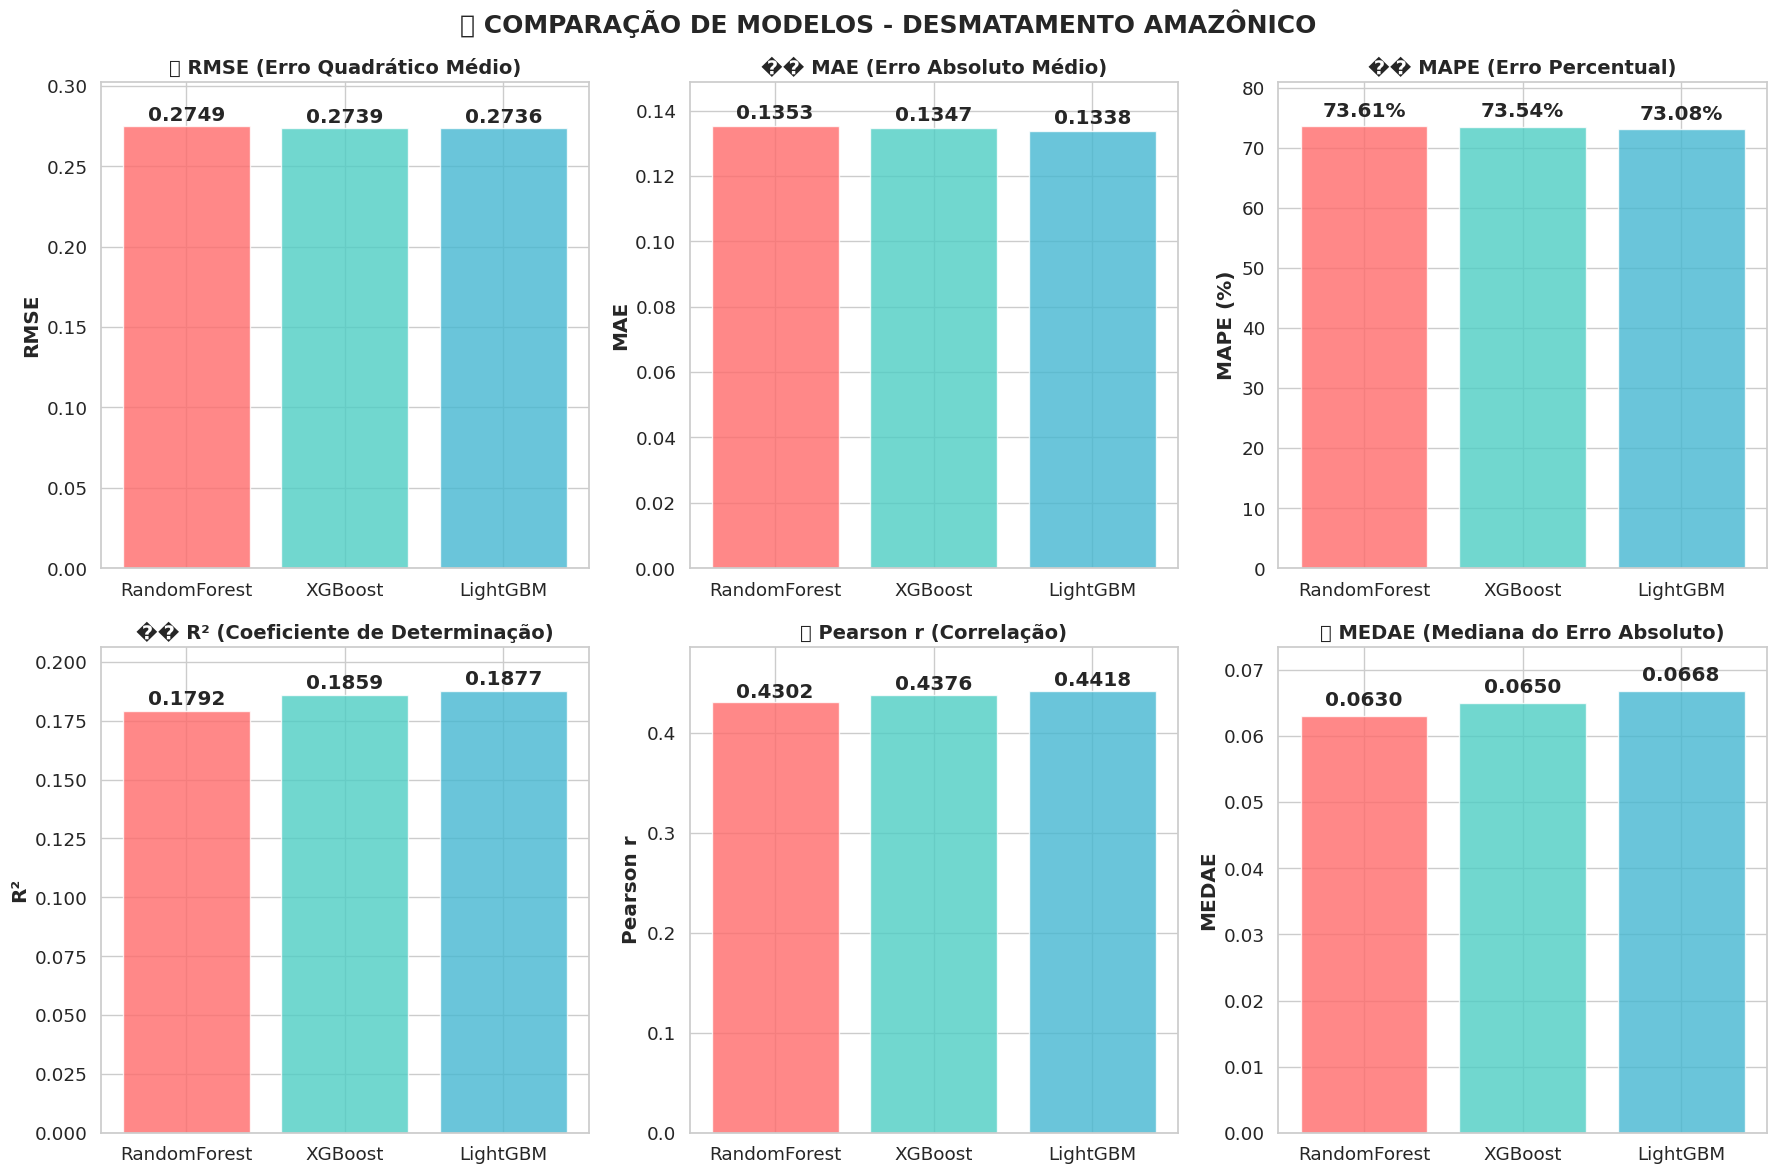

✅ Gráficos de comparação gerados com sucesso!
📈 Gerando gráficos de linha para métricas de ajuste...


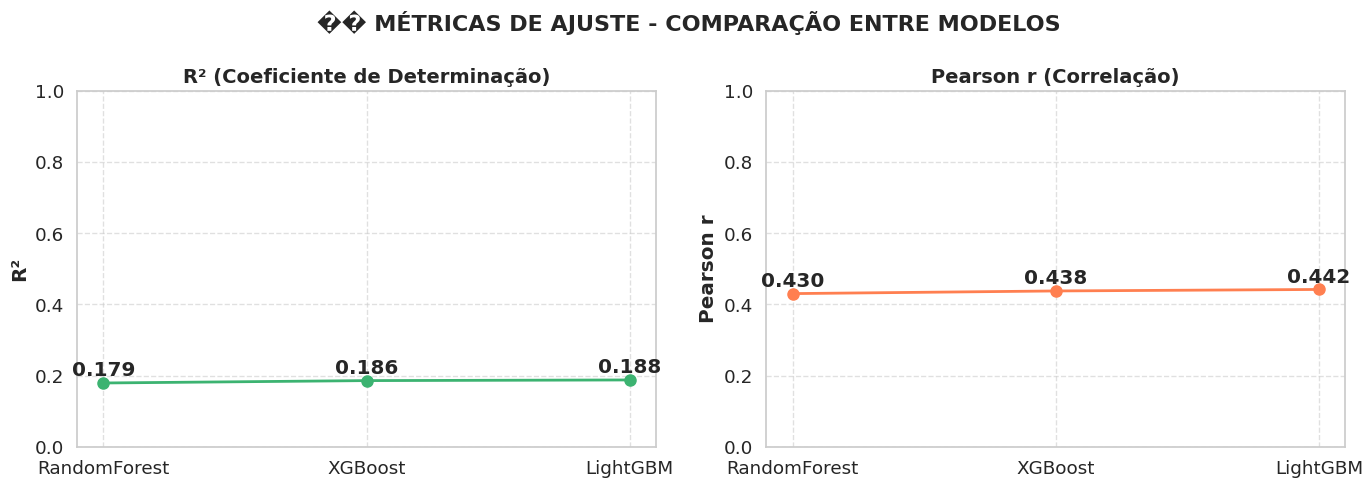

✅ Gráficos de linha gerados com sucesso!

🏋️ PASSO 6: Treinando modelos finais...
🚀 Modo forçado: treinando todos os modelos...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 18573, number of used features: 9
[LightGBM] [Info] Start training from score 0.173881

📊 PASSO 7: Gerando gráficos de previsões...
📊 Gerando gráficos de previsões vs valores reais...


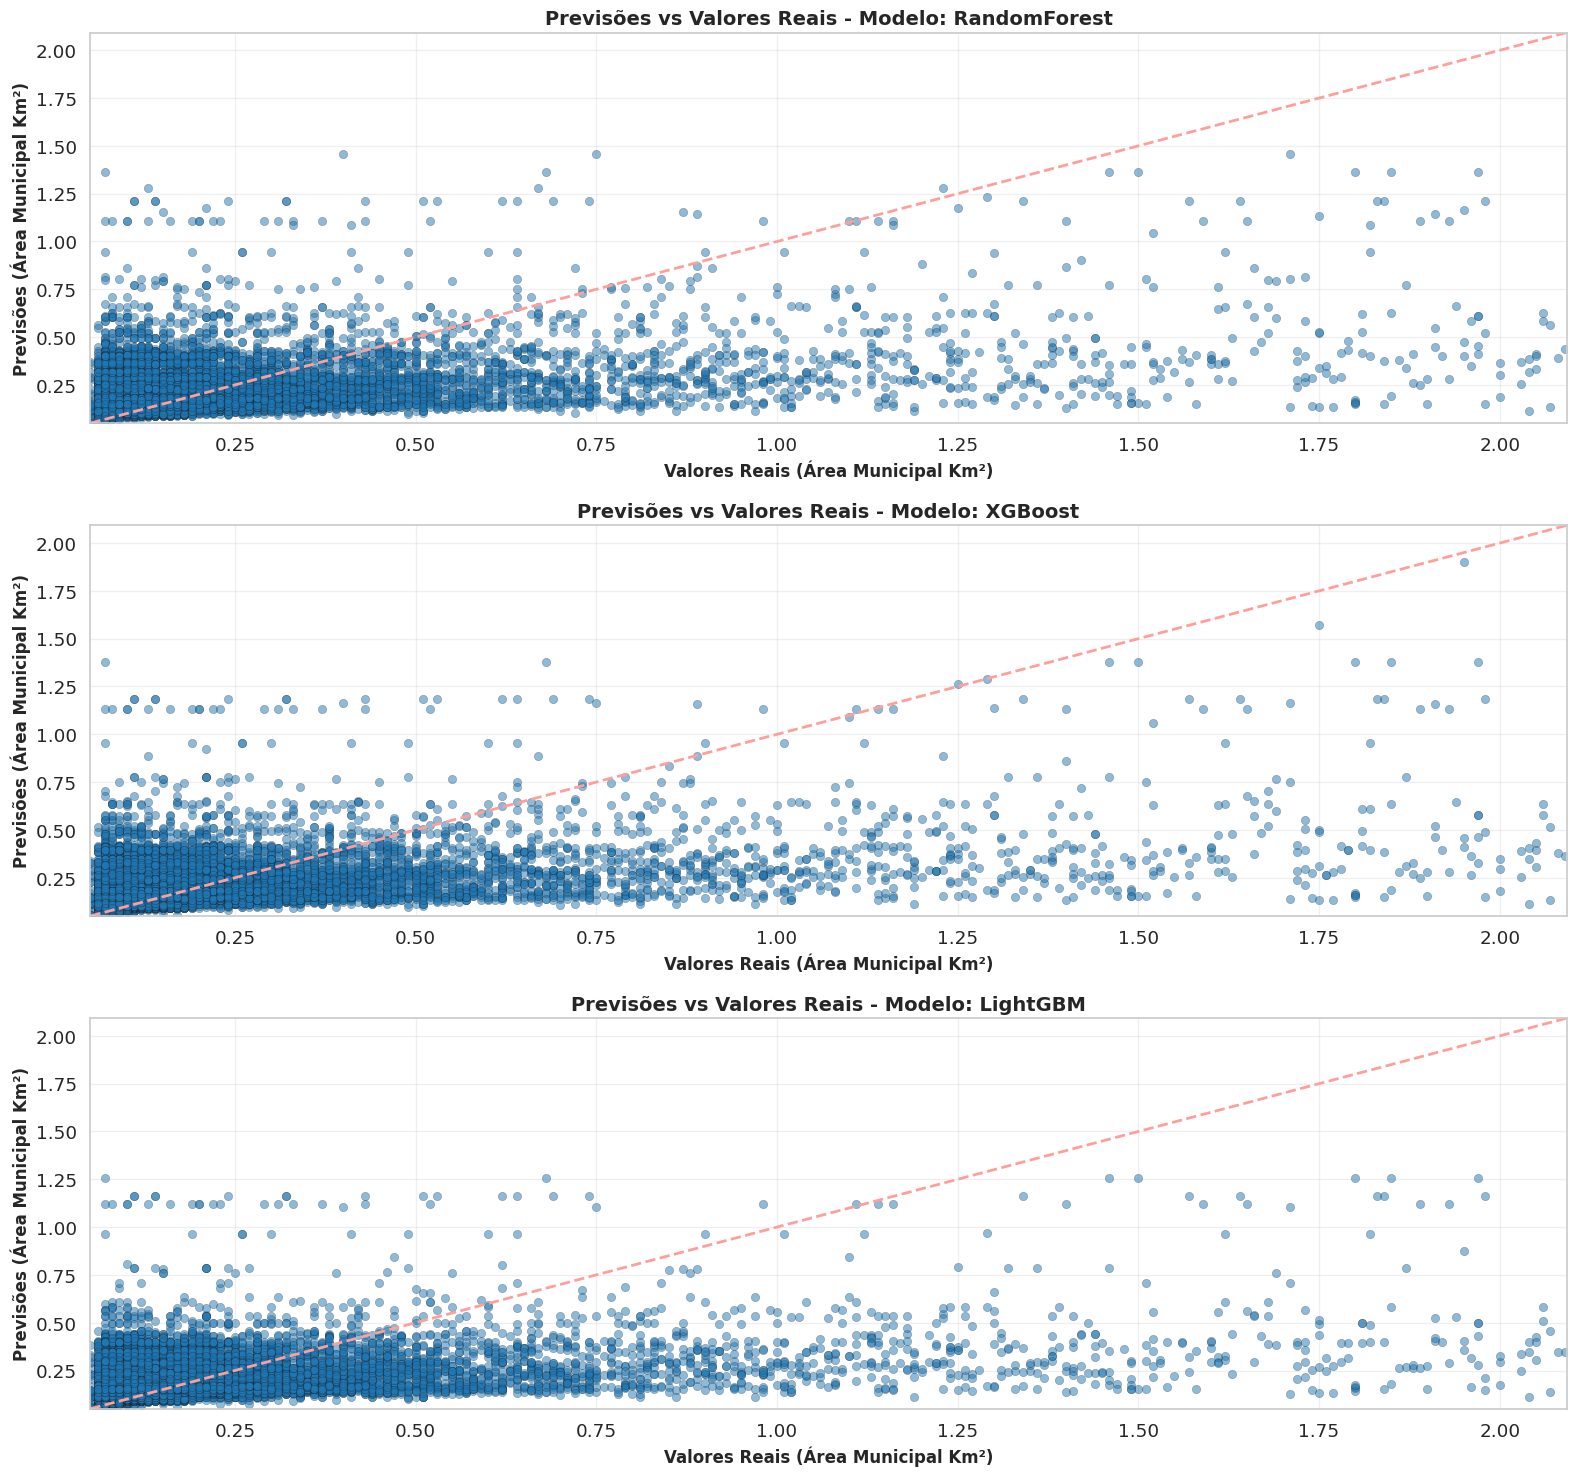

✅ Gráficos de previsões gerados com sucesso!

🎨 PASSO 8: Gerando dashboard comparativo avançado...
🎨 Gerando dashboard comparativo avançado...


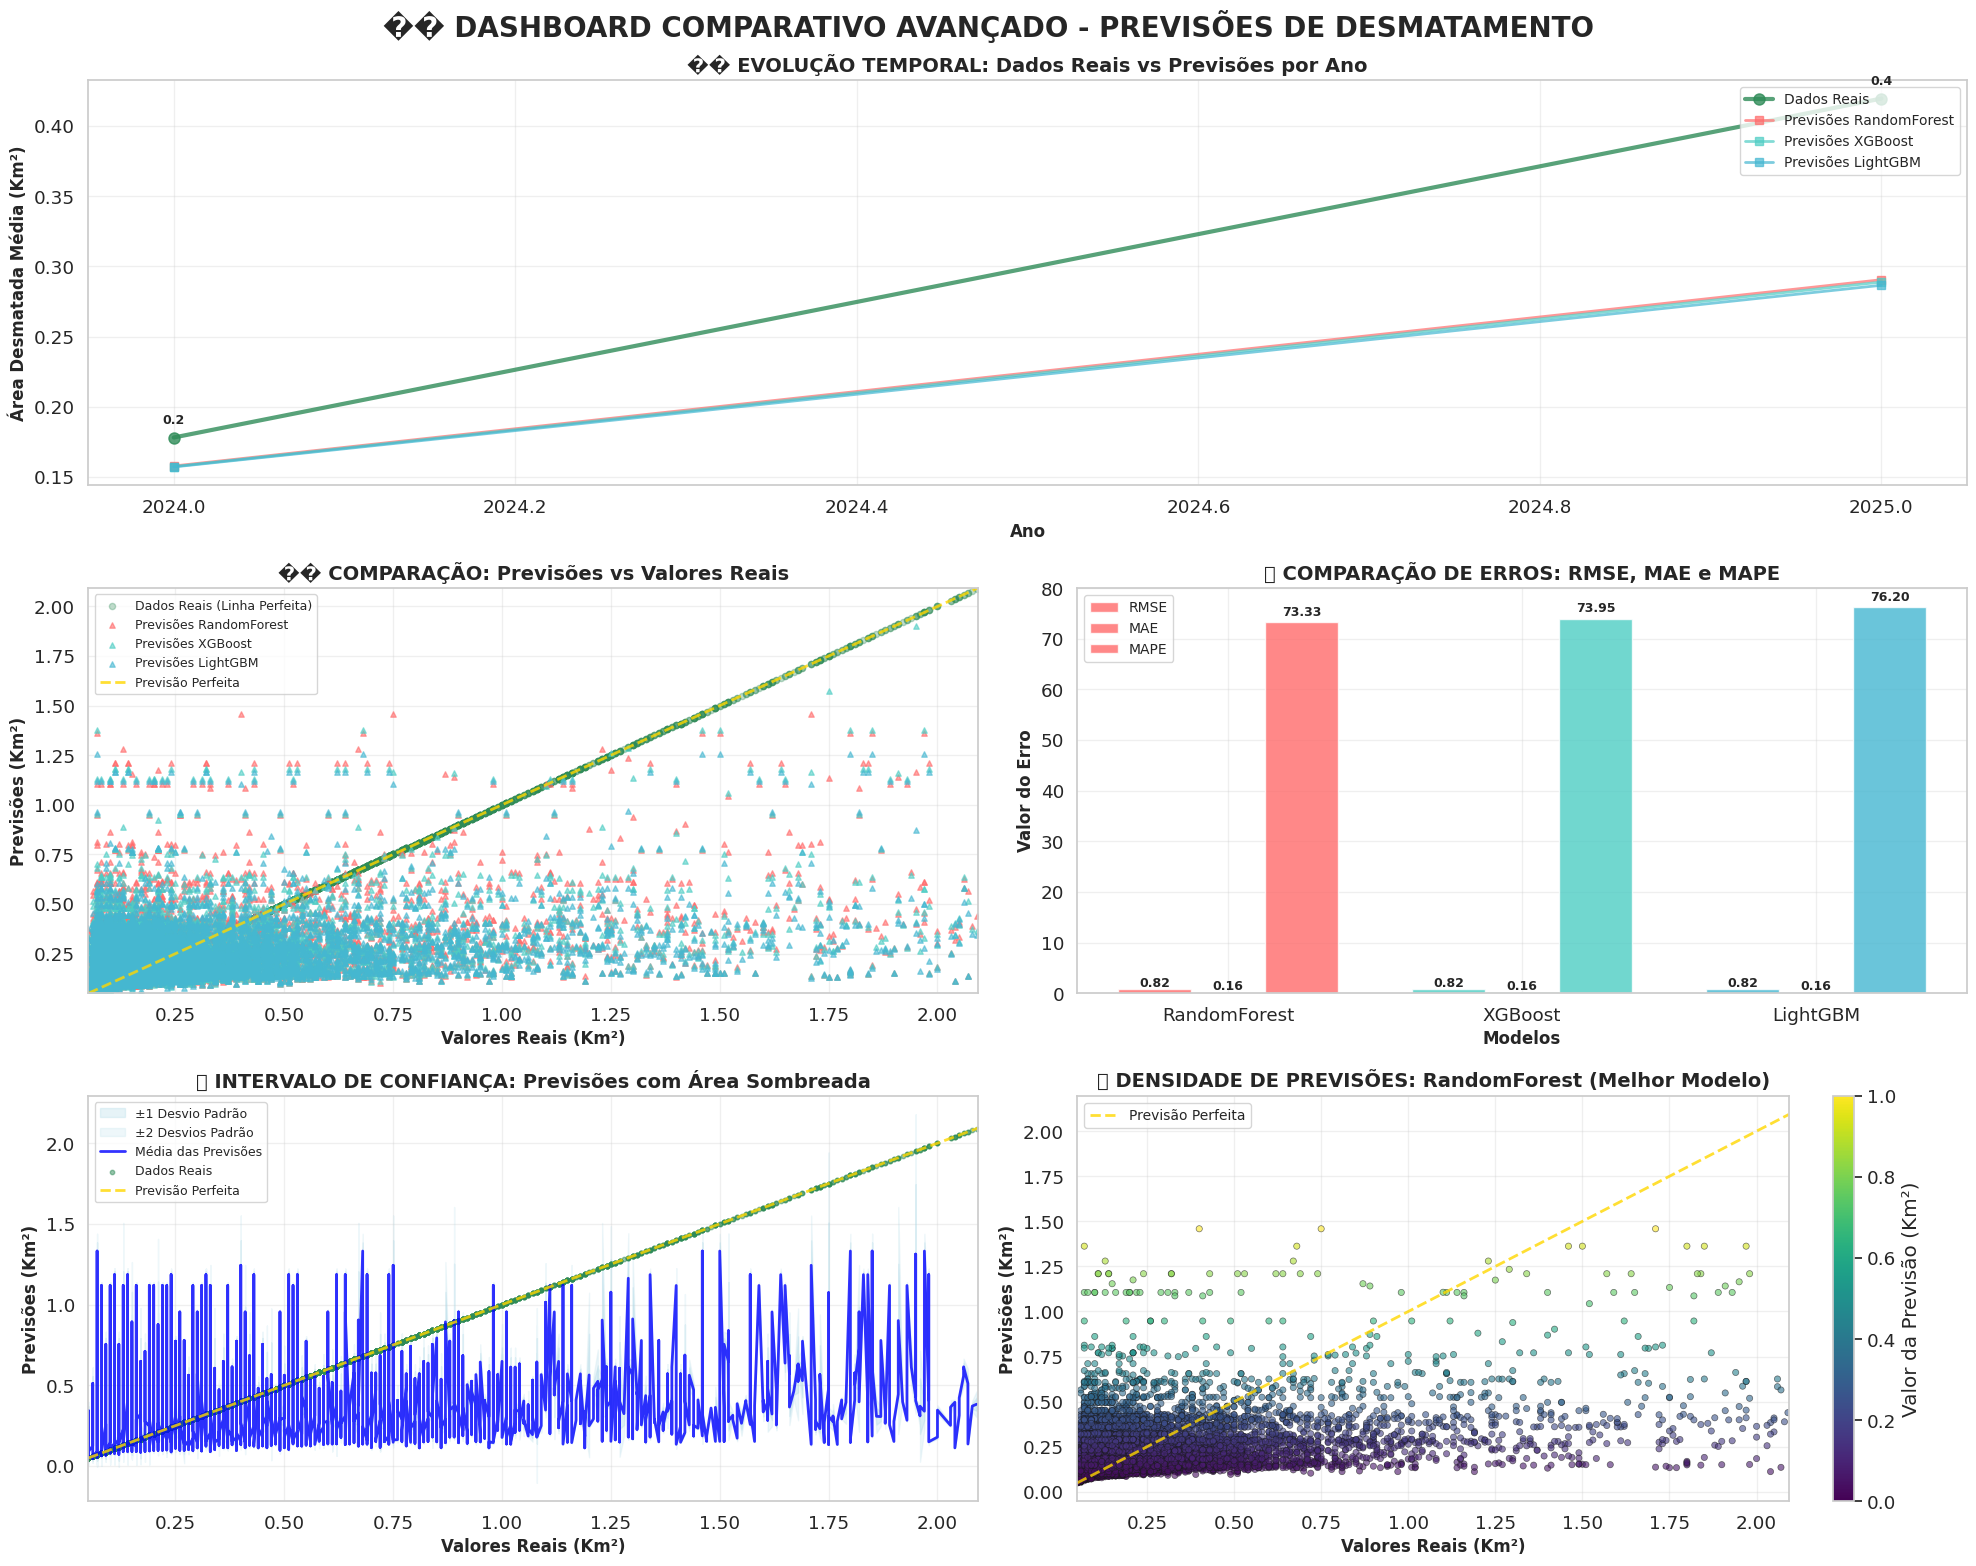

✅ Dashboard comparativo avançado gerado com sucesso!

📝 PASSO 9: Exibindo resultados comparativos...

🌳 RESULTADOS DE PREVISÃO DE DESMATAMENTO - COMPARAÇÃO COMPLETA

🥇 1º RandomForest – Previsão vs Área Real
--------------------------------------------------------------------------------
📊 Métricas de Performance:
   • RMSE: 0.8154 km²
   • MAE: 0.1598 km²
   • MAPE: 73.33%
   • R²: 0.0926
   • Pearson r: 0.3803

�� Amostras de Previsões vs Valores Reais:
   Amostra 1:
     �� Data: 2024-10-04 00:00:00
     🏛️ UF: AM
     🌳 Área Real: 0.0700 km²
     🎯 Previsão: 0.1681 km²
     ❌ Erro Absoluto: 0.0981 km²
     �� Erro Percentual: 140.1%

   Amostra 2:
     �� Data: 2024-10-08 00:00:00
     🏛️ UF: MT
     🌳 Área Real: 0.0900 km²
     🎯 Previsão: 0.2298 km²
     ❌ Erro Absoluto: 0.1398 km²
     �� Erro Percentual: 155.4%

   Amostra 3:
     �� Data: 2024-11-23 00:00:00
     🏛️ UF: PA
     🌳 Área Real: 0.2800 km²
     🎯 Previsão: 0.1605 km²
     ❌ Erro Absoluto: 0.1195 km²
     �� Erro Pe

In [38]:
# =========================================
# 9. Execução principal (célula de teste)
# =========================================

# Cria instância da classe principal
predictor = PreditordeDesmatamentoAvancado()

# Verifica se a classe foi criada corretamente
print("✅ Classe criada com sucesso!")
print(f"Métodos disponíveis: {[method for method in dir(predictor) if not method.startswith('_')]}")

# Testa um método simples primeiro
print("\n�� Testando método de verificação...")
try:
    modelos_existentes = predictor.verificar_modelos_existentes()
    print("✅ Método verificar_modelos_existentes funcionou!")
except Exception as e:
    print(f"❌ Erro: {e}")

# Agora tenta o pipeline completo
print("\n🚀 Executando pipeline completo...")
try:
    resumo_cv, modelos_treinados, preds_finais = predictor.pipeline_completo("dados_desmatamento.csv")

    # Mensagem de conclusão com formatação visual
    print("\n" + "=" * 60)
    print("🎉 ANÁLISE CONCLUÍDA COM SUCESSO!")
    print("🎨 DASHBOARD VISUAL COMPLETO GERADO!")
    print("=" * 60)

except Exception as e:
    print(f"❌ Erro no pipeline: {e}")
    print("🔍 Verificando se o método existe...")
    if hasattr(predictor, 'pipeline_completo'):
        print("✅ Método pipeline_completo existe na classe")
    else:
        print("❌ Método pipeline_completo NÃO existe na classe")

# Instruções para uso avançado
print("\n💡 Para forçar re-treinamento: predictor.pipeline_completo('dados_desmatamento.csv', forcar_treinamento=True)")
print("=" * 60)